In [6]:
import pandas as pd
import numpy as np
import sys
from data_holder import DataHolder
from tqdm import tqdm
import pickle
import math
import time
import multiprocessing as mp
import pickle
import lightgbm as lgb
from const import RAW_DATA_FOLDER, OUTPUT_FOLDER, CACHE_FOLDER
from recaller import calc_and_recall
from csv_handler import create_train_data
from sklearn.model_selection import train_test_split

def read_raw_data(filename, cb=None):
    data = pd.read_csv(RAW_DATA_FOLDER + filename)
    return cb(data) if cb is not None else data

def read_all_raw_data(filenames=['articles.csv', 'train_click_log.csv', 'testA_click_log.csv']):
    return DataHolder(*[read_raw_data(filename) for filename in filenames])

def calc_mrr_and_hit(recommend_dict, y, k=5):
    #assert len(recommend_dict) == len(y)
    sum_mrr = 0.0
    sum_hit = 0.0
    sum_hit_detail = np.repeat(0.0, 5)
    user_cnt = len(recommend_dict.keys())

    for user_id, recommend_items in recommend_dict.items():
        answer = y[user_id] if user_id in y else -1
        if (answer in recommend_items) and (recommend_items.index(answer) < k):
            sum_hit += 1
            sum_mrr += 1 / (recommend_items.index(answer) + 1)
            sum_hit_detail[recommend_items.index(answer)] += 1

    return (sum_mrr / user_cnt), (sum_hit / user_cnt), (sum_hit_detail / user_cnt)

def create_submission(recommend_dict):
    _data = [{'user_id': user_id,
        'article_1': art_id_list[0],
        'article_2': art_id_list[1],
        'article_3': art_id_list[2],
        'article_4': art_id_list[3],
        'article_5': art_id_list[4]} for user_id, art_id_list in tqdm(recommend_dict.items())]
    _t = pd.DataFrame(_data)
    _t.sort_values('user_id', inplace=True)
    _t.to_csv(OUTPUT_FOLDER + 'result.csv', index=False)

def handler(offline=True):
    cpu_cores = mp.cpu_count()
    print('使用CPU核心数: {}'.format(cpu_cores))
    print('开始{}数据验证处理'.format('线下' if offline else '线上'))
    raw_data = read_all_raw_data()
    test_users = raw_data.get_test_users(offline)

    _user_id_list = list(test_users.keys())
    user_id_min = np.min(_user_id_list)
    user_id_max = np.max(_user_id_list)
    print('获得{}用户集合{}件 [{} ~ {}]'.format('验证' if offline else '测试', len(test_users), user_id_min, user_id_max))

    dataset = raw_data.get_item_dt_groupby_user()

    if offline:
        train_dataset, y_answer = raw_data.get_train_dataset_and_answers(test_users)
    else:
        train_dataset = raw_data.get_train_dataset_for_online(test_users)
        y_answer = None

    print('训练数据({}件)'.format(np.sum([len(ts_list) for user_id, ts_list in train_dataset.items()])))

    articles_dic = dict(list(raw_data.get_articles().apply(lambda x: (x['article_id'], dict(x)), axis=1)))
    print('获得文章字典({}件)'.format(len(articles_dic.keys())))

    recall_results = calc_and_recall(dataset, train_dataset, test_users, articles_dic, cpu_cores, offline, y_answer)
    create_train_data(raw_data, train_dataset, test_users, articles_dic, recall_results, offline, y_answer)

def make_train_data():
    handler()

def make_test_data():
    handler(False)

def prepare_dataset(df):
    agg_column = [column for column in df.columns if column != 'user_id'][0]
    df.sort_values('user_id', inplace=True)
    grp_info = df.groupby('user_id', as_index=False).count()[agg_column].values
    y = df['answer'] if 'answer' in df.columns else None
    return df.drop(columns=['answer']) if 'answer' in df.columns else df, grp_info, y

def make_recommend_dict(X_val, y_pred):
    X_val['pred'] = y_pred
    _t = X_val.groupby('user_id')\
        .apply(lambda x: list(x.sort_values('pred', ascending=False)['article_id'].head(5)))\
        .reset_index()\
        .rename(columns={0: 'item_list'})

    recommend_dict = dict(zip(_t['user_id'], _t['item_list']))    
    return recommend_dict



def test():
    df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')

    users = df_train['user_id'].unique()
    train_users, _test_users = train_test_split(users, test_size=0.2, random_state=98)
    test_users, val_users = train_test_split(_test_users, test_size=0.5, random_state=38)
    df_new_train = df_train.merge(pd.DataFrame(train_users, columns=['user_id']))
    df_test = df_train.merge(pd.DataFrame(test_users, columns=['user_id']))
    df_val = df_train.merge(pd.DataFrame(val_users, columns=['user_id']))

    X_train, X_grp_train, y_train = prepare_dataset(df_new_train)
    X_test, X_grp_test, y_test = prepare_dataset(df_test)
    X_val, X_grp_val, _ = prepare_dataset(df_val)

    def handle_columns(X):
        return X.drop(columns=['user_id', 'article_id'])

    _X_train = handle_columns(X_train)

    clf = lgb.LGBMRanker(random_state=777, n_estimators=1000, early_stopping_rounds=10, verbose=1)
    clf.fit(_X_train, y_train, group=X_grp_train, eval_set=[(handle_columns(X_test), y_test)], eval_group=[X_grp_test], eval_at=[1, 2, 3, 4, 5], eval_metric=['ndcg', ])
    print('Best iteration: {}'.format(clf.best_iteration_))


    for X, X_grp, df, title in [(X_test, X_grp_test, df_test, 'Test Set'), (X_val, X_grp_val, df_val, 'Validation Set')]:
        print('[{}]'.format(title))
        y_pred = clf.predict(handle_columns(X), group=X_grp, num_iteration=clf.best_iteration_)
        recommend_dict = make_recommend_dict(X, y_pred)
        answers = dict(df.loc[df['answer'] == 1, ['user_id', 'article_id']].values)
        mrr, hit, details = calc_mrr_and_hit(recommend_dict, answers)
        print('MRR: {} / HIT: {}'.format(mrr, hit))
        print(' / '.join(['%.2f' % detail for detail in details]))

    for column, score in sorted(zip(_X_train.columns, clf.feature_importances_), key=lambda x: x[1], reverse=True):
        print('{}: {}'.format(column, score))



In [10]:
def test():
    from sklearn.model_selection import GroupKFold
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import ParameterGrid
    import lightgbm as lgb
    from lightgbm import early_stopping, log_evaluation

    # 读取训练数据
    df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')
    users = df_train['user_id'].unique()
    
    # 数据划分(这里不直接分为train/val/test，而是先分出一个测试集用户集合，再对剩余做CV)
    train_users, test_users = train_test_split(users, test_size=0.2, random_state=98)
    # 从剩下的训练用户中分出验证用户
    train_users, val_users = train_test_split(train_users, test_size=0.2, random_state=38)

    # 准备训练集、验证集、测试集的数据
    df_new_train = df_train.merge(pd.DataFrame(train_users, columns=['user_id']))
    df_val = df_train.merge(pd.DataFrame(val_users, columns=['user_id']))
    df_test = df_train.merge(pd.DataFrame(test_users, columns=['user_id']))
    
    X_train, X_grp_train, y_train = prepare_dataset(df_new_train)
    X_val, X_grp_val, y_val = prepare_dataset(df_val)
    X_test, X_grp_test, _ = prepare_dataset(df_test)

    def handle_columns(X):
        return X.drop(columns=['user_id', 'article_id'])

    _X_train = handle_columns(X_train)
    _X_val = handle_columns(X_val)

    # 使用用户ID进行分组交叉验证
    # 注意这里使用train_users的用户ID进行CV
    group_kfold = GroupKFold(n_splits=3)

    # 定义要搜索的参数集合，可根据需要调整
    param_grid = {
        'n_estimators': [500, 1000],
        'num_leaves': [31, 63],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_samples': [20, 50]
    }

    best_score = -np.inf
    best_params = None

    # 将训练集（train_users部分）进行CV
    train_user_ids = X_train['user_id'].values
    # 将y_train转为numpy
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train

    # 对参数网格进行遍历搜索
    for params in ParameterGrid(param_grid):
        cv_scores = []
        for train_index, valid_index in group_kfold.split(_X_train, y_train_np, groups=train_user_ids):
            X_tr_fold, X_val_fold = _X_train.iloc[train_index], _X_train.iloc[valid_index]
            y_tr_fold, y_val_fold = y_train_np[train_index], y_train_np[valid_index]
            
            # group需要对应分块，每个fold需要重新定义group
            # 注意：X_grp_train是按照用户出现顺序统计的，需要与index对应
            # 因此这里需要根据valid_index, train_index对group进行重新计算
            # 简化起见，我们直接利用 "user_id" 分组计数来恢复group信息。
            
            def calc_group(user_ids):
                # 统计每个user_id出现的次数，以此作为group值
                _df = pd.DataFrame({'user_id': user_ids})
                return _df.groupby('user_id', as_index=False).size()['size'].values
            
            train_user_ids_fold = train_user_ids[train_index]
            valid_user_ids_fold = train_user_ids[valid_index]

            grp_train_fold = calc_group(train_user_ids_fold)
            grp_val_fold = calc_group(valid_user_ids_fold)

            callbacks = [
                early_stopping(stopping_rounds=10),
                log_evaluation(period=10)
            ]
            clf = lgb.LGBMRanker(random_state=777, 
                                 eval_at=[1,2,3,4,5],
                                 eval_metric='ndcg',
                                 **params)
            clf.fit(
                X_tr_fold, y_tr_fold, group=grp_train_fold,
                eval_set=[(X_val_fold, y_val_fold)],
                eval_group=[grp_val_fold],
                callbacks=callbacks
            )

            # 使用验证集得分作为衡量标准，这里使用clf.best_score_中'valid_0'的ndcg@5作为比较
            # LightGBM ranker会输出多个ndcg@k值，一般取ndcg@5
            # best_score_['valid_0']['ndcg@5'] 是一个列表，为最后一次评估的分数，可以尝试访问最优迭代对应的值
            # 不同版本的lightgbm输出可能有差异，需要按实际情况调整。
            # 尝试获取ndcg@5分数:
            ndcg_5_scores = clf.best_score_['valid_0'].get('ndcg@5', None)
            if ndcg_5_scores is not None:
                cv_scores.append(ndcg_5_scores)
            else:
                # 如果取不到，则可考虑ndcg@1或其他指标
                # 或者通过中间eval过程自定义保存最优分数。
                pass

        if cv_scores and np.mean(cv_scores) > best_score:
            best_score = np.mean(cv_scores)
            best_params = params

    print("Best CV Score: ", best_score)
    print("Best Params: ", best_params)

    # 使用找到的最佳参数训练最终模型(这里用train+val合并重新训练，也可以只用train训练，看策略而定)
    # 为了简化，这里直接使用train+val作为最终训练集，然后在test和val上进行测试
    combined_X = pd.concat([X_train, X_val], axis=0)
    combined_y = pd.concat([y_train, y_val], axis=0)
    combined_user_ids = combined_X['user_id'].values

    _combined_X = handle_columns(combined_X)
    grp_combined = pd.DataFrame({'user_id': combined_user_ids}).groupby('user_id', as_index=False).size()['size'].values

    final_clf = lgb.LGBMRanker(random_state=777, eval_at=[1,2,3,4,5], eval_metric='ndcg', **best_params)
    final_clf.fit(_combined_X, combined_y, group=grp_combined,
                  early_stopping_rounds=10,
                  verbose=1)

    # 分别在Val和Test集上进行评估
    for X, X_grp, df, title in [(X_val, X_grp_val, df_val, 'Validation Set'), (X_test, X_grp_test, df_test, 'Test Set')]:
        y_pred = final_clf.predict(handle_columns(X), num_iteration=final_clf.best_iteration_)
        recommend_dict = make_recommend_dict(X, y_pred)
        answers = dict(df.loc[df['answer'] == 1, ['user_id', 'article_id']].values)
        mrr, hit, details = calc_mrr_and_hit(recommend_dict, answers)
        print('[{}]'.format(title))
        print('MRR: {} / HIT: {}'.format(mrr, hit))
        print('Detail Hits: ', ' / '.join(['%.2f' % detail for detail in details]))

    # 特征重要性输出
    for column, score in sorted(zip(_combined_X.columns, final_clf.feature_importances_), key=lambda x: x[1], reverse=True):
        print('{}: {}'.format(column, score))


In [12]:
def test():
    from sklearn.model_selection import GroupKFold, ParameterGrid
    import lightgbm as lgb
    import numpy as np
    df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')
    users = df_train['user_id'].unique()
    train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)
    df_train_cv = df_train[df_train['user_id'].isin(train_users)]
    df_test_final = df_train[df_train['user_id'].isin(test_users)]

    X_train_cv, X_grp_train_cv, y_train_cv = prepare_dataset(df_train_cv)
    X_test_final, X_grp_test_final, y_test_final = prepare_dataset(df_test_final)

    def handle_columns(X):
        return X.drop(columns=['user_id', 'article_id'])

    _X_train_cv = handle_columns(X_train_cv)
    y_train_cv_np = y_train_cv.values if hasattr(y_train_cv, 'values') else y_train_cv
    group_array = X_train_cv['user_id'].values

    article_counts = df_train_cv[df_train_cv['answer']==1]['article_id'].value_counts()
    top_articles = article_counts.index[:5].tolist()
    def baseline_recommend(X):
        recommend_dict = {uid: top_articles for uid in X['user_id'].unique()}
        return recommend_dict

    baseline_cv_scores = []
    group_kfold = GroupKFold(n_splits=3)
    for train_idx, val_idx in group_kfold.split(_X_train_cv, y_train_cv_np, groups=group_array):
        val_data = X_train_cv.iloc[val_idx].copy()
        y_val = y_train_cv_np[val_idx]

        answers = {}
        uid_arr = val_data['user_id'].values
        aid_arr = val_data['article_id'].values
        for i, uid in enumerate(uid_arr):
            if y_val[i] == 1:
                answers[uid] = aid_arr[i]
        baseline_recs = baseline_recommend(val_data)
        mrr_b, hit_b, _ = calc_mrr_and_hit(baseline_recs, answers)
        baseline_cv_scores.append((mrr_b, hit_b))

    baseline_mrr_mean = np.mean([s[0] for s in baseline_cv_scores])
    baseline_mrr_std = np.std([s[0] for s in baseline_cv_scores])
    baseline_hit_mean = np.mean([s[1] for s in baseline_cv_scores])
    baseline_hit_std = np.std([s[1] for s in baseline_cv_scores])

    print("Baseline CV Scores:")
    print(f"MRR: mean={baseline_mrr_mean:.4f}, std={baseline_mrr_std:.4f}")
    print(f"HIT: mean={baseline_hit_mean:.4f}, std={baseline_hit_std:.4f}")

    param_grid = {
    'n_estimators': [500],
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.1],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [1.0, 2.0],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    }

    best_score = -np.inf
    best_params = None
    cv_results = []

    for params in ParameterGrid(param_grid):
        fold_scores = []
        for train_idx, val_idx in group_kfold.split(_X_train_cv, y_train_cv_np, groups=group_array):
            X_tr, X_val = _X_train_cv.iloc[train_idx], _X_train_cv.iloc[val_idx]
            y_tr, y_val = y_train_cv_np[train_idx], y_train_cv_np[val_idx]

            def calc_group(user_ids):
                _df = pd.DataFrame({'user_id': user_ids})
                return _df.groupby('user_id', as_index=False).size()['size'].values

            train_user_ids_fold = group_array[train_idx]
            val_user_ids_fold = group_array[val_idx]
            grp_train_fold = calc_group(train_user_ids_fold)
            grp_val_fold = calc_group(val_user_ids_fold)

            clf = lgb.LGBMRanker(random_state=777, eval_at=[1,2,3,4,5], eval_metric='ndcg', **params)
            from lightgbm import early_stopping
            clf.fit(X_tr, y_tr, group=grp_train_fold,
                    eval_set=[(X_val, y_val)],
                    eval_group=[grp_val_fold],
                    callbacks=[early_stopping(stopping_rounds=10, first_metric_only=True)])

            val_data = X_train_cv.iloc[val_idx].copy()
            val_data['pred'] = clf.predict(X_val, num_iteration=clf.best_iteration_)
            recommend_dict = make_recommend_dict(val_data, val_data['pred'])
            y_val = y_train_cv_np[val_idx]

            answers = {}
            uid_arr = val_data['user_id'].values
            aid_arr = val_data['article_id'].values
            for i, uid in enumerate(uid_arr):
                if y_val[i] == 1:
                    answers[uid] = aid_arr[i]
            mrr, hit, _details = calc_mrr_and_hit(recommend_dict, answers)
            fold_scores.append((mrr, hit))

        avg_mrr = np.mean([s[0] for s in fold_scores])
        std_mrr = np.std([s[0] for s in fold_scores])
        avg_hit = np.mean([s[1] for s in fold_scores])
        std_hit = np.std([s[1] for s in fold_scores])
        cv_results.append((params, avg_mrr, std_mrr, avg_hit, std_hit))

        if avg_mrr > best_score:
            best_score = avg_mrr
            best_params = params

    print("Cross Validation Results (LGBMRanker):")
    for r in cv_results:
        print("Params:", r[0], 
              "Avg MRR: {:.4f}".format(r[1]), "Std MRR: {:.4f}".format(r[2]), 
              "Avg HIT: {:.4f}".format(r[3]), "Std HIT: {:.4f}".format(r[4]))

    print("Best Params based on CV:", best_params)
    print("Best Avg MRR from CV:", best_score)

    combined_user_ids = X_train_cv['user_id'].values
    grp_combined = pd.DataFrame({'user_id': combined_user_ids}).groupby('user_id', as_index=False).size()['size'].values

    final_clf = lgb.LGBMRanker(random_state=777, eval_at=[1,2,3,4,5], eval_metric='ndcg', **best_params)
    from lightgbm import early_stopping
    final_clf.fit(_X_train_cv, y_train_cv, group=grp_combined,)

    _X_test_final = handle_columns(X_test_final)
    y_pred_test = final_clf.predict(_X_test_final, num_iteration=final_clf.best_iteration_)
    recommend_dict_test = make_recommend_dict(X_test_final, y_pred_test)
    answers_test = dict(df_test_final.loc[df_test_final['answer'] == 1, ['user_id', 'article_id']].values)
    mrr_test, hit_test, details_test = calc_mrr_and_hit(recommend_dict_test, answers_test)
    print("\n=== Test Set Results ===")
    print(f"Model MRR: {mrr_test:.4f} / HIT: {hit_test:.4f}")
    print("Detail Hits:", " / ".join(['%.2f' % d for d in details_test]))

    baseline_recs_test = baseline_recommend(X_test_final)
    mrr_b_test, hit_b_test, _ = calc_mrr_and_hit(baseline_recs_test, answers_test)
    print("Baseline on Test Set - MRR: {:.4f} / HIT: {:.4f}".format(mrr_b_test, hit_b_test))
    print("Comparison: Model improves over baseline by {:.4f} in MRR and {:.4f} in HIT".format(mrr_test - mrr_b_test, hit_test - hit_b_test))
    feature_importance = sorted(zip(_X_train_cv.columns, final_clf.feature_importances_), key=lambda x: x[1], reverse=True)
    print("\nFeature Importances:")
    for f, imp in feature_importance:
        print(f"{f}: {imp}")

    return final_clf, feature_importance, _X_test_final, recommend_dict_test, answers_test 



In [13]:
final_clf, feature_importance, _X_test_final, recommend_dict_test, answers_test  = test()

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)


Baseline CV Scores:
MRR: mean=0.0286, std=0.0005
HIT: mean=0.0583, std=0.0004


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's ndcg@1: 0.613065	valid_0's ndcg@2: 0.712723	valid_0's ndcg@3: 0.762393	valid_0's ndcg@4: 0.790722	valid_0's ndcg@5: 0.806143
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002542 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's ndcg@1: 0.597293	valid_0's ndcg@2: 0.696379	valid_0's ndcg@3: 0.748484	valid_0's ndcg@4: 0.779331	valid_0's ndcg@5: 0.79642
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.610342	valid_0's ndcg@2: 0.707985	valid_0's ndcg@3: 0.759341	valid_0's ndcg@4: 0.787733	valid_0's ndcg@5: 0.804459
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[134]	valid_0's ndcg@1: 0.613065	valid_0's ndcg@2: 0.712723	valid_0's ndcg@3: 0.762393	valid_0's ndcg@4: 0.790722	valid_0's ndcg@5: 0.806143
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's ndcg@1: 0.597293	valid_0's ndcg@2: 0.696379	valid_0's ndcg@3: 0.748484	valid_0's ndcg@4: 0.779331	valid_0's ndcg@5: 0.79642
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.610342	valid_0's ndcg@2: 0.707985	valid_0's ndcg@3: 0.759341	valid_0's ndcg@4: 0.787733	valid_0's ndcg@5: 0.804459
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's ndcg@1: 0.610403	valid_0's ndcg@2: 0.710392	valid_0's ndcg@3: 0.760156	valid_0's ndcg@4: 0.788952	valid_0's ndcg@5: 0.804417
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.602167	valid_0's ndcg@2: 0.701372	valid_0's ndcg@3: 0.753796	valid_0's ndcg@4: 0.783109	valid_0's ndcg@5: 0.799371
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's ndcg@1: 0.615855	valid_0's ndcg@2: 0.713687	valid_0's ndcg@3: 0.763955	valid_0's ndcg@4: 0.791895	valid_0's ndcg@5: 0.808041
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's ndcg@1: 0.610403	valid_0's ndcg@2: 0.710392	valid_0's ndcg@3: 0.760156	valid_0's ndcg@4: 0.788952	valid_0's ndcg@5: 0.804417
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[90]	valid_0's ndcg@1: 0.602167	valid_0's ndcg@2: 0.701372	valid_0's ndcg@3: 0.753796	valid_0's ndcg@4: 0.783109	valid_0's ndcg@5: 0.799371
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's ndcg@1: 0.615855	valid_0's ndcg@2: 0.713687	valid_0's ndcg@3: 0.763955	valid_0's ndcg@4: 0.791895	valid_0's ndcg@5: 0.808041
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's ndcg@1: 0.59964	valid_0's ndcg@2: 0.699629	valid_0's ndcg@3: 0.752955	valid_0's ndcg@4: 0.782011	valid_0's ndcg@5: 0.798273
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's ndcg@1: 0.593355	valid_0's ndcg@2: 0.694169	valid_0's ndcg@3: 0.74483	valid_0's ndcg@4: 0.776081	valid_0's ndcg@5: 0.793649
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's ndcg@1: 0.595943	valid_0's ndcg@2: 0.693491	valid_0's ndcg@3: 0.746572	valid_0's ndcg@4: 0.778048	valid_0's ndcg@5: 0.796037
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's ndcg@1: 0.59964	valid_0's ndcg@2: 0.699629	valid_0's ndcg@3: 0.752955	valid_0's ndcg@4: 0.782011	valid_0's ndcg@5: 0.798273
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's ndcg@1: 0.593355	valid_0's ndcg@2: 0.694169	valid_0's ndcg@3: 0.74483	valid_0's ndcg@4: 0.776081	valid_0's ndcg@5: 0.793649
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	valid_0's ndcg@1: 0.595943	valid_0's ndcg@2: 0.693491	valid_0's ndcg@3: 0.746572	valid_0's ndcg@4: 0.778048	valid_0's ndcg@5: 0.796037
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.601965	valid_0's ndcg@2: 0.702238	valid_0's ndcg@3: 0.754871	valid_0's ndcg@4: 0.783781	valid_0's ndcg@5: 0.79984
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's ndcg@1: 0.59748	valid_0's ndcg@2: 0.696353	valid_0's ndcg@3: 0.748084	valid_0's ndcg@4: 0.779157	valid_0's ndcg@5: 0.796144
Evaluated only: ndcg@1


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's ndcg@1: 0.601867	valid_0's ndcg@2: 0.699014	valid_0's ndcg@3: 0.751401	valid_0's ndcg@4: 0.782457	valid_0's ndcg@5: 0.799271
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.601965	valid_0's ndcg@2: 0.702238	valid_0's ndcg@3: 0.754871	valid_0's ndcg@4: 0.783781	valid_0's ndcg@5: 0.79984
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's ndcg@1: 0.59748	valid_0's ndcg@2: 0.696353	valid_0's ndcg@3: 0.748084	valid_0's ndcg@4: 0.779157	valid_0's ndcg@5: 0.796144
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's ndcg@1: 0.601867	valid_0's ndcg@2: 0.699014	valid_0's ndcg@3: 0.751401	valid_0's ndcg@4: 0.782457	valid_0's ndcg@5: 0.799271
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[237]	valid_0's ndcg@1: 0.636316	valid_0's ndcg@2: 0.734483	valid_0's ndcg@3: 0.781697	valid_0's ndcg@4: 0.806488	valid_0's ndcg@5: 0.820154
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's ndcg@1: 0.62493	valid_0's ndcg@2: 0.724678	valid_0's ndcg@3: 0.772678	valid_0's ndcg@4: 0.799293	valid_0's ndcg@5: 0.813263
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.629955	valid_0's ndcg@2: 0.726083	valid_0's ndcg@3: 0.774214	valid_0's ndcg@4: 0.800733	valid_0's ndcg@5: 0.815631
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[237]	valid_0's ndcg@1: 0.636316	valid_0's ndcg@2: 0.734483	valid_0's ndcg@3: 0.781697	valid_0's ndcg@4: 0.806488	valid_0's ndcg@5: 0.820154
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[171]	valid_0's ndcg@1: 0.62493	valid_0's ndcg@2: 0.724678	valid_0's ndcg@3: 0.772678	valid_0's ndcg@4: 0.799293	valid_0's ndcg@5: 0.813263
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.629955	valid_0's ndcg@2: 0.726083	valid_0's ndcg@3: 0.774214	valid_0's ndcg@4: 0.800733	valid_0's ndcg@5: 0.815631
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@1: 0.623303	valid_0's ndcg@2: 0.720784	valid_0's ndcg@3: 0.769479	valid_0's ndcg@4: 0.797145	valid_0's ndcg@5: 0.811783
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's ndcg@1: 0.61713	valid_0's ndcg@2: 0.71508	valid_0's ndcg@3: 0.764767	valid_0's ndcg@4: 0.792659	valid_0's ndcg@5: 0.808195
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.635467	valid_0's ndcg@2: 0.732732	valid_0's ndcg@3: 0.778743	valid_0's ndcg@4: 0.804939	valid_0's ndcg@5: 0.819634
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@1: 0.623303	valid_0's ndcg@2: 0.720784	valid_0's ndcg@3: 0.769479	valid_0's ndcg@4: 0.797145	valid_0's ndcg@5: 0.811783
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[64]	valid_0's ndcg@1: 0.61713	valid_0's ndcg@2: 0.71508	valid_0's ndcg@3: 0.764767	valid_0's ndcg@4: 0.792659	valid_0's ndcg@5: 0.808195
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.635467	valid_0's ndcg@2: 0.732732	valid_0's ndcg@3: 0.778743	valid_0's ndcg@4: 0.804939	valid_0's ndcg@5: 0.819634
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's ndcg@1: 0.609128	valid_0's ndcg@2: 0.706396	valid_0's ndcg@3: 0.75946	valid_0's ndcg@4: 0.787417	valid_0's ndcg@5: 0.803331
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's ndcg@1: 0.60813	valid_0's ndcg@2: 0.707098	valid_0's ndcg@3: 0.757254	valid_0's ndcg@4: 0.787034	valid_0's ndcg@5: 0.802673
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's ndcg@1: 0.61803	valid_0's ndcg@2: 0.716714	valid_0's ndcg@3: 0.765969	valid_0's ndcg@4: 0.793925	valid_0's ndcg@5: 0.809477
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's ndcg@1: 0.609128	valid_0's ndcg@2: 0.706396	valid_0's ndcg@3: 0.75946	valid_0's ndcg@4: 0.787417	valid_0's ndcg@5: 0.803331
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	valid_0's ndcg@1: 0.60813	valid_0's ndcg@2: 0.707098	valid_0's ndcg@3: 0.757254	valid_0's ndcg@4: 0.787034	valid_0's ndcg@5: 0.802673
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[92]	valid_0's ndcg@1: 0.61803	valid_0's ndcg@2: 0.716714	valid_0's ndcg@3: 0.765969	valid_0's ndcg@4: 0.793925	valid_0's ndcg@5: 0.809477
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's ndcg@1: 0.609165	valid_0's ndcg@2: 0.708492	valid_0's ndcg@3: 0.760206	valid_0's ndcg@4: 0.788179	valid_0's ndcg@5: 0.803818
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's ndcg@1: 0.613042	valid_0's ndcg@2: 0.711655	valid_0's ndcg@3: 0.761942	valid_0's ndcg@4: 0.790173	valid_0's ndcg@5: 0.805681
Evaluated only: ndcg@1


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[231]	valid_0's ndcg@1: 0.627967	valid_0's ndcg@2: 0.726296	valid_0's ndcg@3: 0.773246	valid_0's ndcg@4: 0.800281	valid_0's ndcg@5: 0.815064
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's ndcg@1: 0.609165	valid_0's ndcg@2: 0.708492	valid_0's ndcg@3: 0.760206	valid_0's ndcg@4: 0.788179	valid_0's ndcg@5: 0.803818
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[109]	valid_0's ndcg@1: 0.613042	valid_0's ndcg@2: 0.711655	valid_0's ndcg@3: 0.761942	valid_0's ndcg@4: 0.790173	valid_0's ndcg@5: 0.805681
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[231]	valid_0's ndcg@1: 0.627967	valid_0's ndcg@2: 0.726296	valid_0's ndcg@3: 0.773246	valid_0's ndcg@4: 0.800281	valid_0's ndcg@5: 0.815064
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's ndcg@1: 0.633241	valid_0's ndcg@2: 0.732331	valid_0's ndcg@3: 0.780051	valid_0's ndcg@4: 0.805214	valid_0's ndcg@5: 0.818822
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's ndcg@1: 0.63393	valid_0's ndcg@2: 0.733465	valid_0's ndcg@3: 0.779102	valid_0's ndcg@4: 0.804458	valid_0's ndcg@5: 0.818805
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's ndcg@1: 0.641692	valid_0's ndcg@2: 0.738554	valid_0's ndcg@3: 0.783554	valid_0's ndcg@4: 0.809071	valid_0's ndcg@5: 0.822606
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's ndcg@1: 0.633241	valid_0's ndcg@2: 0.732331	valid_0's ndcg@3: 0.780051	valid_0's ndcg@4: 0.805214	valid_0's ndcg@5: 0.818822
Evaluated only: ndcg@1


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[179]	valid_0's ndcg@1: 0.63393	valid_0's ndcg@2: 0.733465	valid_0's ndcg@3: 0.779102	valid_0's ndcg@4: 0.804458	valid_0's ndcg@5: 0.818805
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[163]	valid_0's ndcg@1: 0.641692	valid_0's ndcg@2: 0.738554	valid_0's ndcg@3: 0.783554	valid_0's ndcg@4: 0.809071	valid_0's ndcg@5: 0.822606
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's ndcg@1: 0.638566	valid_0's ndcg@2: 0.735337	valid_0's ndcg@3: 0.782757	valid_0's ndcg@4: 0.807064	valid_0's ndcg@5: 0.82057
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's ndcg@1: 0.63138	valid_0's ndcg@2: 0.729661	valid_0's ndcg@3: 0.776461	valid_0's ndcg@4: 0.802899	valid_0's ndcg@5: 0.817202
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's ndcg@1: 0.639705	valid_0's ndcg@2: 0.73633	valid_0's ndcg@3: 0.782792	valid_0's ndcg@4: 0.807647	valid_0's ndcg@5: 0.821907
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[141]	valid_0's ndcg@1: 0.638566	valid_0's ndcg@2: 0.735337	valid_0's ndcg@3: 0.782757	valid_0's ndcg@4: 0.807064	valid_0's ndcg@5: 0.82057
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's ndcg@1: 0.63138	valid_0's ndcg@2: 0.729661	valid_0's ndcg@3: 0.776461	valid_0's ndcg@4: 0.802899	valid_0's ndcg@5: 0.817202
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's ndcg@1: 0.639705	valid_0's ndcg@2: 0.73633	valid_0's ndcg@3: 0.782792	valid_0's ndcg@4: 0.807647	valid_0's ndcg@5: 0.821907
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's ndcg@1: 0.633541	valid_0's ndcg@2: 0.732465	valid_0's ndcg@3: 0.780973	valid_0's ndcg@4: 0.805296	valid_0's ndcg@5: 0.819121
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.625605	valid_0's ndcg@2: 0.725566	valid_0's ndcg@3: 0.774053	valid_0's ndcg@4: 0.800459	valid_0's ndcg@5: 0.814052
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.631417	valid_0's ndcg@2: 0.729959	valid_0's ndcg@3: 0.776665	valid_0's ndcg@4: 0.803006	valid_0's ndcg@5: 0.817687
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[207]	valid_0's ndcg@1: 0.633541	valid_0's ndcg@2: 0.732465	valid_0's ndcg@3: 0.780973	valid_0's ndcg@4: 0.805296	valid_0's ndcg@5: 0.819121
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.625605	valid_0's ndcg@2: 0.725566	valid_0's ndcg@3: 0.774053	valid_0's ndcg@4: 0.800459	valid_0's ndcg@5: 0.814052
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.631417	valid_0's ndcg@2: 0.729959	valid_0's ndcg@3: 0.776665	valid_0's ndcg@4: 0.803006	valid_0's ndcg@5: 0.817687
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's ndcg@1: 0.622966	valid_0's ndcg@2: 0.722907	valid_0's ndcg@3: 0.772971	valid_0's ndcg@4: 0.798732	valid_0's ndcg@5: 0.812543
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's ndcg@1: 0.62418	valid_0's ndcg@2: 0.722982	valid_0's ndcg@3: 0.771975	valid_0's ndcg@4: 0.798639	valid_0's ndcg@5: 0.812377
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's ndcg@1: 0.627705	valid_0's ndcg@2: 0.724543	valid_0's ndcg@3: 0.773311	valid_0's ndcg@4: 0.800056	valid_0's ndcg@5: 0.814911
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[82]	valid_0's ndcg@1: 0.622966	valid_0's ndcg@2: 0.722907	valid_0's ndcg@3: 0.772971	valid_0's ndcg@4: 0.798732	valid_0's ndcg@5: 0.812543
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[117]	valid_0's ndcg@1: 0.62418	valid_0's ndcg@2: 0.722982	valid_0's ndcg@3: 0.771975	valid_0's ndcg@4: 0.798639	valid_0's ndcg@5: 0.812377
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[86]	valid_0's ndcg@1: 0.627705	valid_0's ndcg@2: 0.724543	valid_0's ndcg@3: 0.773311	valid_0's ndcg@4: 0.800056	valid_0's ndcg@5: 0.814911
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's ndcg@1: 0.648691	valid_0's ndcg@2: 0.744019	valid_0's ndcg@3: 0.791139	valid_0's ndcg@4: 0.813783	valid_0's ndcg@5: 0.82652
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's ndcg@1: 0.638842	valid_0's ndcg@2: 0.736722	valid_0's ndcg@3: 0.782077	valid_0's ndcg@4: 0.807595	valid_0's ndcg@5: 0.821071
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's ndcg@1: 0.644092	valid_0's ndcg@2: 0.741688	valid_0's ndcg@3: 0.786068	valid_0's ndcg@4: 0.810827	valid_0's ndcg@5: 0.824434
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's ndcg@1: 0.648691	valid_0's ndcg@2: 0.744019	valid_0's ndcg@3: 0.791139	valid_0's ndcg@4: 0.813783	valid_0's ndcg@5: 0.82652
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's ndcg@1: 0.638842	valid_0's ndcg@2: 0.736722	valid_0's ndcg@3: 0.782077	valid_0's ndcg@4: 0.807595	valid_0's ndcg@5: 0.821071
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's ndcg@1: 0.644092	valid_0's ndcg@2: 0.741688	valid_0's ndcg@3: 0.786068	valid_0's ndcg@4: 0.810827	valid_0's ndcg@5: 0.824434
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's ndcg@1: 0.648391	valid_0's ndcg@2: 0.744334	valid_0's ndcg@3: 0.790442	valid_0's ndcg@4: 0.813231	valid_0's ndcg@5: 0.826258
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's ndcg@1: 0.63138	valid_0's ndcg@2: 0.728715	valid_0's ndcg@3: 0.776096	valid_0's ndcg@4: 0.801839	valid_0's ndcg@5: 0.816593
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's ndcg@1: 0.645517	valid_0's ndcg@2: 0.740936	valid_0's ndcg@3: 0.787173	valid_0's ndcg@4: 0.811576	valid_0's ndcg@5: 0.825154
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[101]	valid_0's ndcg@1: 0.648391	valid_0's ndcg@2: 0.744334	valid_0's ndcg@3: 0.790442	valid_0's ndcg@4: 0.813231	valid_0's ndcg@5: 0.826258
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	valid_0's ndcg@1: 0.63138	valid_0's ndcg@2: 0.728715	valid_0's ndcg@3: 0.776096	valid_0's ndcg@4: 0.801839	valid_0's ndcg@5: 0.816593
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	valid_0's ndcg@1: 0.645517	valid_0's ndcg@2: 0.740936	valid_0's ndcg@3: 0.787173	valid_0's ndcg@4: 0.811576	valid_0's ndcg@5: 0.825154
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.635716	valid_0's ndcg@2: 0.734617	valid_0's ndcg@3: 0.782862	valid_0's ndcg@4: 0.807605	valid_0's ndcg@5: 0.820371
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's ndcg@1: 0.629017	valid_0's ndcg@2: 0.728932	valid_0's ndcg@3: 0.776218	valid_0's ndcg@4: 0.802333	valid_0's ndcg@5: 0.815926
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's ndcg@1: 0.638355	valid_0's ndcg@2: 0.736731	valid_0's ndcg@3: 0.783493	valid_0's ndcg@4: 0.808106	valid_0's ndcg@5: 0.821858
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.635716	valid_0's ndcg@2: 0.734617	valid_0's ndcg@3: 0.782862	valid_0's ndcg@4: 0.807605	valid_0's ndcg@5: 0.820371
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's ndcg@1: 0.629017	valid_0's ndcg@2: 0.728932	valid_0's ndcg@3: 0.776218	valid_0's ndcg@4: 0.802333	valid_0's ndcg@5: 0.815926
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[125]	valid_0's ndcg@1: 0.638355	valid_0's ndcg@2: 0.736731	valid_0's ndcg@3: 0.783493	valid_0's ndcg@4: 0.808106	valid_0's ndcg@5: 0.821858
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's ndcg@1: 0.635791	valid_0's ndcg@2: 0.734857	valid_0's ndcg@3: 0.783233	valid_0's ndcg@4: 0.807266	valid_0's ndcg@5: 0.820453
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@1: 0.632017	valid_0's ndcg@2: 0.730346	valid_0's ndcg@3: 0.777521	valid_0's ndcg@4: 0.803813	valid_0's ndcg@5: 0.817348
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's ndcg@1: 0.63543	valid_0's ndcg@2: 0.734161	valid_0's ndcg@3: 0.780904	valid_0's ndcg@4: 0.806195	valid_0's ndcg@5: 0.820006
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[107]	valid_0's ndcg@1: 0.635791	valid_0's ndcg@2: 0.734857	valid_0's ndcg@3: 0.783233	valid_0's ndcg@4: 0.807266	valid_0's ndcg@5: 0.820453
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@1: 0.632017	valid_0's ndcg@2: 0.730346	valid_0's ndcg@3: 0.777521	valid_0's ndcg@4: 0.803813	valid_0's ndcg@5: 0.817348
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[76]	valid_0's ndcg@1: 0.63543	valid_0's ndcg@2: 0.734161	valid_0's ndcg@3: 0.780904	valid_0's ndcg@4: 0.806195	valid_0's ndcg@5: 0.820006
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's ndcg@1: 0.605303	valid_0's ndcg@2: 0.703162	valid_0's ndcg@3: 0.756001	valid_0's ndcg@4: 0.784959	valid_0's ndcg@5: 0.801744
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's ndcg@1: 0.59418	valid_0's ndcg@2: 0.69452	valid_0's ndcg@3: 0.746345	valid_0's ndcg@4: 0.777272	valid_0's ndcg@5: 0.794434
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's ndcg@1: 0.619567	valid_0's ndcg@2: 0.717707	valid_0's ndcg@3: 0.76775	valid_0's ndcg@4: 0.794124	valid_0's ndcg@5: 0.81011
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	valid_0's ndcg@1: 0.605303	valid_0's ndcg@2: 0.703162	valid_0's ndcg@3: 0.756001	valid_0's ndcg@4: 0.784959	valid_0's ndcg@5: 0.801744
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's ndcg@1: 0.59418	valid_0's ndcg@2: 0.69452	valid_0's ndcg@3: 0.746345	valid_0's ndcg@4: 0.777272	valid_0's ndcg@5: 0.794434
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[164]	valid_0's ndcg@1: 0.619567	valid_0's ndcg@2: 0.717707	valid_0's ndcg@3: 0.76775	valid_0's ndcg@4: 0.794124	valid_0's ndcg@5: 0.81011
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's ndcg@1: 0.607065	valid_0's ndcg@2: 0.707196	valid_0's ndcg@3: 0.757129	valid_0's ndcg@4: 0.786523	valid_0's ndcg@5: 0.802554
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's ndcg@1: 0.60738	valid_0's ndcg@2: 0.706182	valid_0's ndcg@3: 0.7581	valid_0's ndcg@4: 0.786718	valid_0's ndcg@5: 0.802545
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's ndcg@1: 0.61668	valid_0's ndcg@2: 0.714749	valid_0's ndcg@3: 0.764454	valid_0's ndcg@4: 0.792523	valid_0's ndcg@5: 0.808292
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[91]	valid_0's ndcg@1: 0.607065	valid_0's ndcg@2: 0.707196	valid_0's ndcg@3: 0.757129	valid_0's ndcg@4: 0.786523	valid_0's ndcg@5: 0.802554
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[149]	valid_0's ndcg@1: 0.60738	valid_0's ndcg@2: 0.706182	valid_0's ndcg@3: 0.7581	valid_0's ndcg@4: 0.786718	valid_0's ndcg@5: 0.802545
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[135]	valid_0's ndcg@1: 0.61668	valid_0's ndcg@2: 0.714749	valid_0's ndcg@3: 0.764454	valid_0's ndcg@4: 0.792523	valid_0's ndcg@5: 0.808292
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's ndcg@1: 0.589065	valid_0's ndcg@2: 0.688865	valid_0's ndcg@3: 0.742866	valid_0's ndcg@4: 0.774748	valid_0's ndcg@5: 0.791881
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's ndcg@1: 0.60063	valid_0's ndcg@2: 0.701562	valid_0's ndcg@3: 0.752355	valid_0's ndcg@4: 0.782297	valid_0's ndcg@5: 0.798559
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's ndcg@1: 0.601042	valid_0's ndcg@2: 0.698141	valid_0's ndcg@3: 0.750303	valid_0's ndcg@4: 0.782087	valid_0's ndcg@5: 0.798828
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's ndcg@1: 0.589065	valid_0's ndcg@2: 0.688865	valid_0's ndcg@3: 0.742866	valid_0's ndcg@4: 0.774748	valid_0's ndcg@5: 0.791881
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[113]	valid_0's ndcg@1: 0.60063	valid_0's ndcg@2: 0.701562	valid_0's ndcg@3: 0.752355	valid_0's ndcg@4: 0.782297	valid_0's ndcg@5: 0.798559
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[60]	valid_0's ndcg@1: 0.601042	valid_0's ndcg@2: 0.698141	valid_0's ndcg@3: 0.750303	valid_0's ndcg@4: 0.782087	valid_0's ndcg@5: 0.798828
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's ndcg@1: 0.592927	valid_0's ndcg@2: 0.691497	valid_0's ndcg@3: 0.746154	valid_0's ndcg@4: 0.776502	valid_0's ndcg@5: 0.793925
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@1: 0.597855	valid_0's ndcg@2: 0.696373	valid_0's ndcg@3: 0.748985	valid_0's ndcg@4: 0.779348	valid_0's ndcg@5: 0.796219
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's ndcg@1: 0.59943	valid_0's ndcg@2: 0.696434	valid_0's ndcg@3: 0.748727	valid_0's ndcg@4: 0.779687	valid_0's ndcg@5: 0.797516
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's ndcg@1: 0.592927	valid_0's ndcg@2: 0.691497	valid_0's ndcg@3: 0.746154	valid_0's ndcg@4: 0.776502	valid_0's ndcg@5: 0.793925
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	valid_0's ndcg@1: 0.597855	valid_0's ndcg@2: 0.696373	valid_0's ndcg@3: 0.748985	valid_0's ndcg@4: 0.779348	valid_0's ndcg@5: 0.796219
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	valid_0's ndcg@1: 0.59943	valid_0's ndcg@2: 0.696434	valid_0's ndcg@3: 0.748727	valid_0's ndcg@4: 0.779687	valid_0's ndcg@5: 0.797516
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's ndcg@1: 0.621016	valid_0's ndcg@2: 0.718355	valid_0's ndcg@3: 0.768137	valid_0's ndcg@4: 0.79582	valid_0's ndcg@5: 0.810167
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's ndcg@1: 0.618967	valid_0's ndcg@2: 0.716255	valid_0's ndcg@3: 0.766055	valid_0's ndcg@4: 0.794011	valid_0's ndcg@5: 0.808866
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's ndcg@1: 0.616867	valid_0's ndcg@2: 0.712831	valid_0's ndcg@3: 0.762105	valid_0's ndcg@4: 0.791224	valid_0's ndcg@5: 0.807486
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003691 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	valid_0's ndcg@1: 0.621016	valid_0's ndcg@2: 0.718355	valid_0's ndcg@3: 0.768137	valid_0's ndcg@4: 0.79582	valid_0's ndcg@5: 0.810167
Evaluated only: ndcg@1


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's ndcg@1: 0.618967	valid_0's ndcg@2: 0.716255	valid_0's ndcg@3: 0.766055	valid_0's ndcg@4: 0.794011	valid_0's ndcg@5: 0.808866
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's ndcg@1: 0.616867	valid_0's ndcg@2: 0.712831	valid_0's ndcg@3: 0.762105	valid_0's ndcg@4: 0.791224	valid_0's ndcg@5: 0.807486
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's ndcg@1: 0.627653	valid_0's ndcg@2: 0.726932	valid_0's ndcg@3: 0.774896	valid_0's ndcg@4: 0.800366	valid_0's ndcg@5: 0.814989
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.619117	valid_0's ndcg@2: 0.717612	valid_0's ndcg@3: 0.767168	valid_0's ndcg@4: 0.794704	valid_0's ndcg@5: 0.809443
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's ndcg@1: 0.62433	valid_0's ndcg@2: 0.719252	valid_0's ndcg@3: 0.767889	valid_0's ndcg@4: 0.795732	valid_0's ndcg@5: 0.811631
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[120]	valid_0's ndcg@1: 0.627653	valid_0's ndcg@2: 0.726932	valid_0's ndcg@3: 0.774896	valid_0's ndcg@4: 0.800366	valid_0's ndcg@5: 0.814989
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.619117	valid_0's ndcg@2: 0.717612	valid_0's ndcg@3: 0.767168	valid_0's ndcg@4: 0.794704	valid_0's ndcg@5: 0.809443
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's ndcg@1: 0.62433	valid_0's ndcg@2: 0.719252	valid_0's ndcg@3: 0.767889	valid_0's ndcg@4: 0.795732	valid_0's ndcg@5: 0.811631
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.619215	valid_0's ndcg@2: 0.717998	valid_0's ndcg@3: 0.769037	valid_0's ndcg@4: 0.795443	valid_0's ndcg@5: 0.809849
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.613155	valid_0's ndcg@2: 0.713117	valid_0's ndcg@3: 0.763628	valid_0's ndcg@4: 0.791762	valid_0's ndcg@5: 0.806211
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's ndcg@1: 0.621142	valid_0's ndcg@2: 0.72082	valid_0's ndcg@3: 0.768932	valid_0's ndcg@4: 0.796436	valid_0's ndcg@5: 0.811465
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003692 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[119]	valid_0's ndcg@1: 0.619215	valid_0's ndcg@2: 0.717998	valid_0's ndcg@3: 0.769037	valid_0's ndcg@4: 0.795443	valid_0's ndcg@5: 0.809849
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	valid_0's ndcg@1: 0.613155	valid_0's ndcg@2: 0.713117	valid_0's ndcg@3: 0.763628	valid_0's ndcg@4: 0.791762	valid_0's ndcg@5: 0.806211
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[123]	valid_0's ndcg@1: 0.621142	valid_0's ndcg@2: 0.72082	valid_0's ndcg@3: 0.768932	valid_0's ndcg@4: 0.796436	valid_0's ndcg@5: 0.811465
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's ndcg@1: 0.621203	valid_0's ndcg@2: 0.720033	valid_0's ndcg@3: 0.770022	valid_0's ndcg@4: 0.796428	valid_0's ndcg@5: 0.811022
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's ndcg@1: 0.611467	valid_0's ndcg@2: 0.711358	valid_0's ndcg@3: 0.762057	valid_0's ndcg@4: 0.790498	valid_0's ndcg@5: 0.805309
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's ndcg@1: 0.615255	valid_0's ndcg@2: 0.713253	valid_0's ndcg@3: 0.762677	valid_0's ndcg@4: 0.791311	valid_0's ndcg@5: 0.80737
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's ndcg@1: 0.621203	valid_0's ndcg@2: 0.720033	valid_0's ndcg@3: 0.770022	valid_0's ndcg@4: 0.796428	valid_0's ndcg@5: 0.811022
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[95]	valid_0's ndcg@1: 0.611467	valid_0's ndcg@2: 0.711358	valid_0's ndcg@3: 0.762057	valid_0's ndcg@4: 0.790498	valid_0's ndcg@5: 0.805309
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	valid_0's ndcg@1: 0.615255	valid_0's ndcg@2: 0.713253	valid_0's ndcg@3: 0.762677	valid_0's ndcg@4: 0.791311	valid_0's ndcg@5: 0.80737
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's ndcg@1: 0.635603	valid_0's ndcg@2: 0.734078	valid_0's ndcg@3: 0.781292	valid_0's ndcg@4: 0.805986	valid_0's ndcg@5: 0.819319
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's ndcg@1: 0.637117	valid_0's ndcg@2: 0.735446	valid_0's ndcg@3: 0.780483	valid_0's ndcg@4: 0.806113	valid_0's ndcg@5: 0.820185
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's ndcg@1: 0.646079	valid_0's ndcg@2: 0.741569	valid_0's ndcg@3: 0.786869	valid_0's ndcg@4: 0.81174	valid_0's ndcg@5: 0.824767
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's ndcg@1: 0.635603	valid_0's ndcg@2: 0.734078	valid_0's ndcg@3: 0.781292	valid_0's ndcg@4: 0.805986	valid_0's ndcg@5: 0.819319
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[147]	valid_0's ndcg@1: 0.637117	valid_0's ndcg@2: 0.735446	valid_0's ndcg@3: 0.780483	valid_0's ndcg@4: 0.806113	valid_0's ndcg@5: 0.820185
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[182]	valid_0's ndcg@1: 0.646079	valid_0's ndcg@2: 0.741569	valid_0's ndcg@3: 0.786869	valid_0's ndcg@4: 0.81174	valid_0's ndcg@5: 0.824767
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's ndcg@1: 0.636503	valid_0's ndcg@2: 0.73557	valid_0's ndcg@3: 0.783158	valid_0's ndcg@4: 0.807417	valid_0's ndcg@5: 0.820488
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.63558	valid_0's ndcg@2: 0.733838	valid_0's ndcg@3: 0.779887	valid_0's ndcg@4: 0.805808	valid_0's ndcg@5: 0.819256
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's ndcg@1: 0.63438	valid_0's ndcg@2: 0.732898	valid_0's ndcg@3: 0.779097	valid_0's ndcg@4: 0.805406	valid_0's ndcg@5: 0.819275
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's ndcg@1: 0.636503	valid_0's ndcg@2: 0.73557	valid_0's ndcg@3: 0.783158	valid_0's ndcg@4: 0.807417	valid_0's ndcg@5: 0.820488
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[153]	valid_0's ndcg@1: 0.63558	valid_0's ndcg@2: 0.733838	valid_0's ndcg@3: 0.779887	valid_0's ndcg@4: 0.805808	valid_0's ndcg@5: 0.819256
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[97]	valid_0's ndcg@1: 0.63438	valid_0's ndcg@2: 0.732898	valid_0's ndcg@3: 0.779097	valid_0's ndcg@4: 0.805406	valid_0's ndcg@5: 0.819275
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@1: 0.628741	valid_0's ndcg@2: 0.729061	valid_0's ndcg@3: 0.778281	valid_0's ndcg@4: 0.80325	valid_0's ndcg@5: 0.81651
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's ndcg@1: 0.628155	valid_0's ndcg@2: 0.727336	valid_0's ndcg@3: 0.775166	valid_0's ndcg@4: 0.8012	valid_0's ndcg@5: 0.814982
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's ndcg@1: 0.635167	valid_0's ndcg@2: 0.73352	valid_0's ndcg@3: 0.780413	valid_0's ndcg@4: 0.806576	valid_0's ndcg@5: 0.820039
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[115]	valid_0's ndcg@1: 0.628741	valid_0's ndcg@2: 0.729061	valid_0's ndcg@3: 0.778281	valid_0's ndcg@4: 0.80325	valid_0's ndcg@5: 0.81651
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[152]	valid_0's ndcg@1: 0.628155	valid_0's ndcg@2: 0.727336	valid_0's ndcg@3: 0.775166	valid_0's ndcg@4: 0.8012	valid_0's ndcg@5: 0.814982
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's ndcg@1: 0.635167	valid_0's ndcg@2: 0.73352	valid_0's ndcg@3: 0.780413	valid_0's ndcg@4: 0.806576	valid_0's ndcg@5: 0.820039
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's ndcg@1: 0.633578	valid_0's ndcg@2: 0.734325	valid_0's ndcg@3: 0.782551	valid_0's ndcg@4: 0.807261	valid_0's ndcg@5: 0.819549
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's ndcg@1: 0.623355	valid_0's ndcg@2: 0.722961	valid_0's ndcg@3: 0.771842	valid_0's ndcg@4: 0.799007	valid_0's ndcg@5: 0.812556
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's ndcg@1: 0.63333	valid_0's ndcg@2: 0.730854	valid_0's ndcg@3: 0.777223	valid_0's ndcg@4: 0.803693	valid_0's ndcg@5: 0.818243
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's ndcg@1: 0.633578	valid_0's ndcg@2: 0.734325	valid_0's ndcg@3: 0.782551	valid_0's ndcg@4: 0.807261	valid_0's ndcg@5: 0.819549
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[104]	valid_0's ndcg@1: 0.623355	valid_0's ndcg@2: 0.722961	valid_0's ndcg@3: 0.771842	valid_0's ndcg@4: 0.799007	valid_0's ndcg@5: 0.812556
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's ndcg@1: 0.63333	valid_0's ndcg@2: 0.730854	valid_0's ndcg@3: 0.777223	valid_0's ndcg@4: 0.803693	valid_0's ndcg@5: 0.818243
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's ndcg@1: 0.651316	valid_0's ndcg@2: 0.748111	valid_0's ndcg@3: 0.793506	valid_0's ndcg@4: 0.81581	valid_0's ndcg@5: 0.828214
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's ndcg@1: 0.635842	valid_0's ndcg@2: 0.735733	valid_0's ndcg@3: 0.781201	valid_0's ndcg@4: 0.806024	valid_0's ndcg@5: 0.820052
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's ndcg@1: 0.644504	valid_0's ndcg@2: 0.740349	valid_0's ndcg@3: 0.785968	valid_0's ndcg@4: 0.810758	valid_0's ndcg@5: 0.823974
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[189]	valid_0's ndcg@1: 0.651316	valid_0's ndcg@2: 0.748111	valid_0's ndcg@3: 0.793506	valid_0's ndcg@4: 0.81581	valid_0's ndcg@5: 0.828214
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	valid_0's ndcg@1: 0.635842	valid_0's ndcg@2: 0.735733	valid_0's ndcg@3: 0.781201	valid_0's ndcg@4: 0.806024	valid_0's ndcg@5: 0.820052
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's ndcg@1: 0.644504	valid_0's ndcg@2: 0.740349	valid_0's ndcg@3: 0.785968	valid_0's ndcg@4: 0.810758	valid_0's ndcg@5: 0.823974
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's ndcg@1: 0.650266	valid_0's ndcg@2: 0.746943	valid_0's ndcg@3: 0.79155	valid_0's ndcg@4: 0.814775	valid_0's ndcg@5: 0.827483
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's ndcg@1: 0.644804	valid_0's ndcg@2: 0.741501	valid_0's ndcg@3: 0.786988	valid_0's ndcg@4: 0.811779	valid_0's ndcg@5: 0.824574
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's ndcg@1: 0.645479	valid_0's ndcg@2: 0.742531	valid_0's ndcg@3: 0.787305	valid_0's ndcg@4: 0.811838	valid_0's ndcg@5: 0.824981
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[138]	valid_0's ndcg@1: 0.650266	valid_0's ndcg@2: 0.746943	valid_0's ndcg@3: 0.79155	valid_0's ndcg@4: 0.814775	valid_0's ndcg@5: 0.827483
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[185]	valid_0's ndcg@1: 0.644804	valid_0's ndcg@2: 0.741501	valid_0's ndcg@3: 0.786988	valid_0's ndcg@4: 0.811779	valid_0's ndcg@5: 0.824574
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's ndcg@1: 0.645479	valid_0's ndcg@2: 0.742531	valid_0's ndcg@3: 0.787305	valid_0's ndcg@4: 0.811838	valid_0's ndcg@5: 0.824981
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's ndcg@1: 0.634891	valid_0's ndcg@2: 0.734927	valid_0's ndcg@3: 0.782947	valid_0's ndcg@4: 0.807157	valid_0's ndcg@5: 0.820431
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's ndcg@1: 0.629992	valid_0's ndcg@2: 0.729078	valid_0's ndcg@3: 0.77704	valid_0's ndcg@4: 0.80301	valid_0's ndcg@5: 0.816225
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's ndcg@1: 0.640342	valid_0's ndcg@2: 0.73808	valid_0's ndcg@3: 0.784523	valid_0's ndcg@4: 0.808958	valid_0's ndcg@5: 0.822899
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[93]	valid_0's ndcg@1: 0.634891	valid_0's ndcg@2: 0.734927	valid_0's ndcg@3: 0.782947	valid_0's ndcg@4: 0.807157	valid_0's ndcg@5: 0.820431
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's ndcg@1: 0.629992	valid_0's ndcg@2: 0.729078	valid_0's ndcg@3: 0.77704	valid_0's ndcg@4: 0.80301	valid_0's ndcg@5: 0.816225
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[105]	valid_0's ndcg@1: 0.640342	valid_0's ndcg@2: 0.73808	valid_0's ndcg@3: 0.784523	valid_0's ndcg@4: 0.808958	valid_0's ndcg@5: 0.822899
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.637178	valid_0's ndcg@2: 0.735488	valid_0's ndcg@3: 0.783358	valid_0's ndcg@4: 0.807842	valid_0's ndcg@5: 0.820841
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's ndcg@1: 0.629955	valid_0's ndcg@2: 0.730153	valid_0's ndcg@3: 0.777777	valid_0's ndcg@4: 0.803618	valid_0's ndcg@5: 0.816949
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's ndcg@1: 0.63753	valid_0's ndcg@2: 0.737775	valid_0's ndcg@3: 0.783037	valid_0's ndcg@4: 0.808102	valid_0's ndcg@5: 0.821927
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2902
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[88]	valid_0's ndcg@1: 0.637178	valid_0's ndcg@2: 0.735488	valid_0's ndcg@3: 0.783358	valid_0's ndcg@4: 0.807842	valid_0's ndcg@5: 0.820841
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2899
[LightGBM] [Info] Number of data points in the train set: 311006, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[96]	valid_0's ndcg@1: 0.629955	valid_0's ndcg@2: 0.730153	valid_0's ndcg@3: 0.777777	valid_0's ndcg@4: 0.803618	valid_0's ndcg@5: 0.816949
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2905
[LightGBM] [Info] Number of data points in the train set: 311010, number of used features: 18
[LightGBM] [Warning] Unknown parameter: eval_metric
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[103]	valid_0's ndcg@1: 0.63753	valid_0's ndcg@2: 0.737775	valid_0's ndcg@3: 0.783037	valid_0's ndcg@4: 0.808102	valid_0's ndcg@5: 0.821927
Evaluated only: ndcg@1
[LightGBM] [Warning] Unknown parameter: eval_metric


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


Cross Validation Results (LGBMRanker):
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.7} Avg MRR: 0.4302 Std MRR: 0.0054 Avg HIT: 0.6613 Std HIT: 0.0014
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.9} Avg MRR: 0.4302 Std MRR: 0.0054 Avg HIT: 0.6613 Std HIT: 0.0014
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.7} Avg MRR: 0.4323 Std MRR: 0.0046 Avg HIT: 0.6614 Std HIT: 0.0020
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'subsample': 0.9} Avg MRR: 0.4323 Std MRR: 0.0046 Avg HIT: 0.6614 Std HIT: 0.0020
Params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 500, 'num_leaves': 31, 'reg_

/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric

=== Test Set Results ===
Model MRR: 0.4633 / HIT: 0.6643
Detail Hits: 0.34 / 0.16 / 0.09 / 0.05 / 0.03
Baseline on Test Set - MRR: 0.0282 / HIT: 0.0602
Comparison: Model improves over baseline by 0.4351 in MRR and 0.6041 in HIT

Feature Importances:
lag_period_last_article: 3549
lag_between_created_at_ts_and_clicked_ts: 3147
last_clicked_timestamp: 2776
words_count: 2449
diff_words_last_article: 2409
category_id: 2120
created_at_ts: 2034
lag_between_two_click: 2010
min_words_count: 1938
max_words_count: 1894
lag_between_two_articles: 1850
avg_words_count: 1806
click_region: 1466
click_referrer_type: 716
click_os: 435
click_deviceGroup: 261
click_country: 107
click_environment: 33


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_97159/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\


In [49]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRanker
from sklearn.model_selection import ParameterGrid
from sklearn.impute import SimpleImputer


def handle_columns(X):
    return X.drop(columns=['user_id', 'article_id'])

df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')

users = df_train['user_id'].unique()
train_users, _test_users = train_test_split(users, test_size=0.2, random_state=98)
test_users, val_users = train_test_split(_test_users, test_size=0.5, random_state=38)

df_new_train = df_train.merge(pd.DataFrame(train_users, columns=['user_id']))
df_test = df_train.merge(pd.DataFrame(test_users, columns=['user_id']))
df_val = df_train.merge(pd.DataFrame(val_users, columns=['user_id']))

X_train, X_grp_train, y_train = prepare_dataset(df_new_train)
X_test, X_grp_test, y_test = prepare_dataset(df_test)
X_val, X_grp_val, y_val = prepare_dataset(df_val)

_X_train = handle_columns(X_train)
_X_val = handle_columns(X_val)
_X_test = handle_columns(X_test)

imputer = SimpleImputer(strategy='median')
_X_train = pd.DataFrame(imputer.fit_transform(_X_train), columns=_X_train.columns)
_X_val = pd.DataFrame(imputer.transform(_X_val), columns=_X_val.columns)
_X_test = pd.DataFrame(imputer.transform(_X_test), columns=_X_test.columns)

group_array = X_train['user_id'].values
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train

def calc_group(user_ids):
    _df = pd.DataFrame({'user_id': user_ids})
    return _df.groupby('user_id', as_index=False).size()['size'].values

def cv_search(model_class, param_grid, fit_func, predict_func, model_name, is_ranker=False):
    best_score = -np.inf
    best_params = None
    cv_results = []
    kfold = GroupKFold(n_splits=3)

    for params in ParameterGrid(param_grid):
        fold_scores = []
        for tr_idx, val_idx in kfold.split(_X_train, y_train_np, groups=group_array):
            X_tr_fold, X_val_fold = _X_train.iloc[tr_idx], _X_train.iloc[val_idx]
            y_tr_fold, y_val_fold = y_train_np[tr_idx], y_train_np[val_idx]

            grp_tr_fold = calc_group(group_array[tr_idx])
            grp_val_fold = calc_group(group_array[val_idx])

            model = model_class(**params)
            fit_func(model, X_tr_fold, y_tr_fold, grp_tr_fold, X_val_fold, y_val_fold, grp_val_fold)

            val_data = X_train.iloc[val_idx].copy()
            y_pred_val = predict_func(model, X_val_fold, grp_val_fold)
            val_data['pred'] = y_pred_val

            answers = {}
            uid_arr = val_data['user_id'].values
            aid_arr = val_data['article_id'].values
            for i, uid in enumerate(uid_arr):
                if y_val_fold[i] == 1:
                    answers[uid] = aid_arr[i]

            recommend_dict = make_recommend_dict(val_data, val_data['pred'])
            mrr, hit, _details = calc_mrr_and_hit(recommend_dict, answers)
            fold_scores.append((mrr, hit))

        avg_mrr = np.mean([s[0] for s in fold_scores])
        std_mrr = np.std([s[0] for s in fold_scores])
        avg_hit = np.mean([s[1] for s in fold_scores])
        std_hit = np.std([s[1] for s in fold_scores])
        cv_results.append((params, avg_mrr, std_mrr, avg_hit, std_hit))

        if avg_mrr > best_score:
            best_score = avg_mrr
            best_params = params

    print(f"Model: {model_name}")
    for r in cv_results:
        print("Params:", r[0], 
                "Avg MRR: {:.4f}".format(r[1]), "Std MRR: {:.4f}".format(r[2]),
                "Avg HIT: {:.4f}".format(r[3]), "Std HIT: {:.4f}".format(r[4]))
    print("Best Params:", best_params)
    print("Best MRR:", best_score)
    print("")
    combined_X = pd.concat([X_train, X_val], axis=0)
    combined_y = pd.concat([y_train, y_val], axis=0)

    _combined_X = handle_columns(combined_X)
    _combined_X = pd.DataFrame(imputer.fit_transform(_combined_X), columns=_combined_X.columns)

    combined_user_ids = combined_X['user_id'].values
    grp_combined = calc_group(combined_user_ids)

    final_model = model_class(**best_params)
    if model_name == "XGBRanker":
        final_model.set_params(objective='rank:ndcg', eval_metric='ndcg@5')
        final_model.fit(_combined_X, combined_y, group=grp_combined, verbose=False)
    else:
        final_model.fit(_combined_X, combined_y)

    _X_test_imp = pd.DataFrame(imputer.transform(_X_test), columns=_X_test.columns)
    y_pred_test = predict_func(final_model, _X_test_imp, X_grp_test)

    df_test_copy = X_test.copy()
    df_test_copy['pred'] = y_pred_test

    y_test_np = y_test.values if hasattr(y_test, 'values') else y_test
    answers_test = {}
    uid_arr = df_test_copy['user_id'].values
    aid_arr = df_test_copy['article_id'].values
    for i, uid in enumerate(uid_arr):
        if y_test_np[i] == 1:
            answers_test[uid] = aid_arr[i]

    recommend_dict_test = make_recommend_dict(df_test_copy, df_test_copy['pred'])
    mrr_test, hit_test, details_test = calc_mrr_and_hit(recommend_dict_test, answers_test)
    print(f"=== {model_name} Test Set Results ===")
    print(f"MRR: {mrr_test:.4f} / HIT: {hit_test:.4f}")
    print("Detail Hits:", " / ".join(['%.2f' % d for d in details_test]))

    if model_name == "Logistic Regression":
        coef = final_model.coef_.ravel()
        feature_importances = sorted(zip(_combined_X.columns, coef), key=lambda x: abs(x[1]), reverse=True)
    elif model_name == "Random Forest":
        feature_importances = sorted(zip(_combined_X.columns, final_model.feature_importances_), key=lambda x: x[1], reverse=True)
    else:
        feature_importances = sorted(zip(_combined_X.columns, final_model.feature_importances_), key=lambda x: x[1], reverse=True)

    print("Feature Importances:")
    for f, imp in feature_importances:
        print(f"{f}: {imp}")
    print("\n")

    return best_params, best_score



In [48]:
# 定义三个模型与其fit、predict逻辑
# 1. Logistic Regression
lr_param_grid = {
    'C': [0.01, 0.1, 1],
    'max_iter': [100, 200]
}

def lr_fit_func(model, X_tr, y_tr, grp_tr, X_val, y_val, grp_val):
    model.fit(X_tr, y_tr)

def lr_predict_func(model, X, grp):
    if hasattr(model, 'predict_proba'):
        return model.predict_proba(X)[:,1]
    else:
        return model.predict(X)

# 2. Random Forest Regressor
rf_param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10],
    'random_state': [42]
}

def rf_fit_func(model, X_tr, y_tr, grp_tr, X_val, y_val, grp_val):
    model.fit(X_tr, y_tr)

def rf_predict_func(model, X, grp):
    return model.predict(X)


# 对三个模型进行依次调参和测试
print("=== Logistic Regression CV Search and Test ===")
lr_best_params, lr_best_score = cv_search(LogisticRegression, lr_param_grid, lr_fit_func, lr_predict_func, "Logistic Regression")

print("=== Random Forest CV Search and Test ===")
rf_best_params, rf_best_score = cv_search(RandomForestRegressor, rf_param_grid, rf_fit_func, rf_predict_func, "Random Forest")



=== Logistic Regression CV Search and Test ===


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: Depreca

Model: Logistic Regression
Params: {'C': 0.01, 'max_iter': 100} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Params: {'C': 0.01, 'max_iter': 200} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Params: {'C': 0.1, 'max_iter': 100} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Params: {'C': 0.1, 'max_iter': 200} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Params: {'C': 1, 'max_iter': 100} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Params: {'C': 1, 'max_iter': 200} Avg MRR: 0.2651 Std MRR: 0.0010 Avg HIT: 0.6007 Std HIT: 0.0023
Best Params: {'C': 0.01, 'max_iter': 100}
Best MRR: 0.2650708366792047



/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\


=== Logistic Regression Test Set Results ===
MRR: 0.2666 / HIT: 0.5984
Detail Hits: 0.11 / 0.12 / 0.13 / 0.13 / 0.11
Feature Importances:
created_at_ts: -1.2365427756346053e-12
lag_period_last_article: 1.1365890411037831e-12
last_clicked_timestamp: -9.995373453816677e-14
lag_between_created_at_ts_and_clicked_ts: -1.1305686626901567e-18
category_id: 4.1591008025406245e-19
diff_words_last_article: 2.227290669005748e-19
lag_between_two_articles: 2.02414765824416e-19
min_words_count: 1.9966322436947207e-19
words_count: -1.3751715312742894e-19
avg_words_count: 8.521191377315577e-20
max_words_count: -4.415762199198535e-20
click_region: 1.402501618345316e-20
lag_between_two_click: 8.257407147475113e-21
click_deviceGroup: 2.7341495360761512e-21
click_country: 2.4245770528039104e-21
click_referrer_type: -1.8420133911556715e-21
click_os: 1.1882120262448727e-21
click_environment: -2.080218833420833e-22


=== Random Forest CV Search and Test ===


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: Depreca

Model: Random Forest
Params: {'max_depth': 5, 'n_estimators': 100, 'random_state': 42} Avg MRR: 0.3614 Std MRR: 0.0007 Avg HIT: 0.6402 Std HIT: 0.0009
Params: {'max_depth': 5, 'n_estimators': 300, 'random_state': 42} Avg MRR: 0.3623 Std MRR: 0.0005 Avg HIT: 0.6407 Std HIT: 0.0010
Params: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42} Avg MRR: 0.4076 Std MRR: 0.0018 Avg HIT: 0.6575 Std HIT: 0.0006
Params: {'max_depth': 10, 'n_estimators': 300, 'random_state': 42} Avg MRR: 0.4084 Std MRR: 0.0016 Avg HIT: 0.6574 Std HIT: 0.0005
Best Params: {'max_depth': 10, 'n_estimators': 300, 'random_state': 42}
Best MRR: 0.4084093550727017



/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\


=== Random Forest Test Set Results ===
MRR: 0.4055 / HIT: 0.6536
Detail Hits: 0.26 / 0.16 / 0.11 / 0.08 / 0.05
Feature Importances:
lag_period_last_article: 0.38020290329810746
lag_between_created_at_ts_and_clicked_ts: 0.1180456758283154
words_count: 0.10878327153369272
created_at_ts: 0.09298114665849425
category_id: 0.09131825370000372
click_referrer_type: 0.06877029309311283
last_clicked_timestamp: 0.06346455382396562
diff_words_last_article: 0.014753987785358812
lag_between_two_articles: 0.011860965379470284
lag_between_two_click: 0.011675689576942245
max_words_count: 0.010076900799564768
min_words_count: 0.008925308134296095
avg_words_count: 0.008296355396915233
click_region: 0.00545244340705234
click_deviceGroup: 0.0022120109096096384
click_os: 0.0015386892405669641
click_country: 0.0008374417590296179
click_environment: 0.0008041096755018865


=== XGBRanker CV Search and Test ===


TypeError: fit() got an unexpected keyword argument 'early_stopping_rounds'

In [52]:
print(rf_best_params, rf_best_score)
# 3. XGBRanker
xgb_param_grid = {
    'tree_method': ['hist'], 
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 6],
    'n_estimators': [100, 300],
    'random_state': [42]
}

def xgb_fit_func(model, X_tr, y_tr, grp_tr, X_val, y_val, grp_val):
    # 不在fit中传eval_metric，使用set_params在上面处理
    model.set_params(objective='rank:ndcg', early_stopping_rounds=10)  # 设置排序目标
    model.fit(
        X_tr, y_tr,
        group=grp_tr,
        eval_set=[(X_val, y_val)],
        eval_group=[grp_val],
        verbose=False
    )

def xgb_predict_func(model, X, grp):
    return model.predict(X)
print("=== XGBRanker CV Search and Test ===")
xgb_best_params, xgb_best_score = cv_search(XGBRanker, xgb_param_grid, xgb_fit_func, xgb_predict_func, "XGBRanker")

{'max_depth': 10, 'n_estimators': 300, 'random_state': 42} 0.4084093550727017
=== XGBRanker CV Search and Test ===


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: Depreca

Model: XGBRanker
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'tree_method': 'hist'} Avg MRR: 0.4036 Std MRR: 0.0017 Avg HIT: 0.6571 Std HIT: 0.0017
Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'random_state': 42, 'tree_method': 'hist'} Avg MRR: 0.4091 Std MRR: 0.0015 Avg HIT: 0.6582 Std HIT: 0.0013
Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'random_state': 42, 'tree_method': 'hist'} Avg MRR: 0.4393 Std MRR: 0.0028 Avg HIT: 0.6633 Std HIT: 0.0018
Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'random_state': 42, 'tree_method': 'hist'} Avg MRR: 0.4531 Std MRR: 0.0023 Avg HIT: 0.6657 Std HIT: 0.0016
Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'random_state': 42, 'tree_method': 'hist'} Avg MRR: 0.3879 Std MRR: 0.0053 Avg HIT: 0.6536 Std HIT: 0.0030
Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'random_state': 42, 'tree_method': 'hi

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_57319/4014145428.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\


| Model               | Best Params                                      | CV Avg MRR (±Std)   | CV Avg HIT (±Std)  | Test MRR  | Test HIT |
|---------------------|-------------------------------------------------|---------------------|--------------------|-----------|----------|
| **Baseline (ItemCF)** | -                                               | -        | -      | 0.1222    | 0.4932   |                               |
| **Logistic Regression** | C=0.01, max_iter=100                           | 0.2651 ± 0.0010     | 0.6007 ± 0.0023    | 0.2666    | 0.5984   |
| **Random Forest**     | max_depth=10, random_state=42  | 0.4084 ± 0.0016     | 0.6574 ± 0.0005    | 0.4055    | 0.6536   |
| **XGBRanker**         | max_depth=7, min_child_weight=5, subsample=0.7, colsample_bytree=1.0 random_state=42,  early stopping = 10 | 0.4531 ± 0.0023 | 0.6657 ± 0.0016 | 0.4491    | 0.6588   |
| **LGBMRanker**        | n_estimators=500, colsample_bytree=0.9, num_leaves=63. reg_alpha = 0, reg_lambda=2.0, subsample=0.7, early stopping = 10 | 0.4572 ± 0.0011 | 0.6647 ± 0.0004 | 0.4624    | 0.6657   |

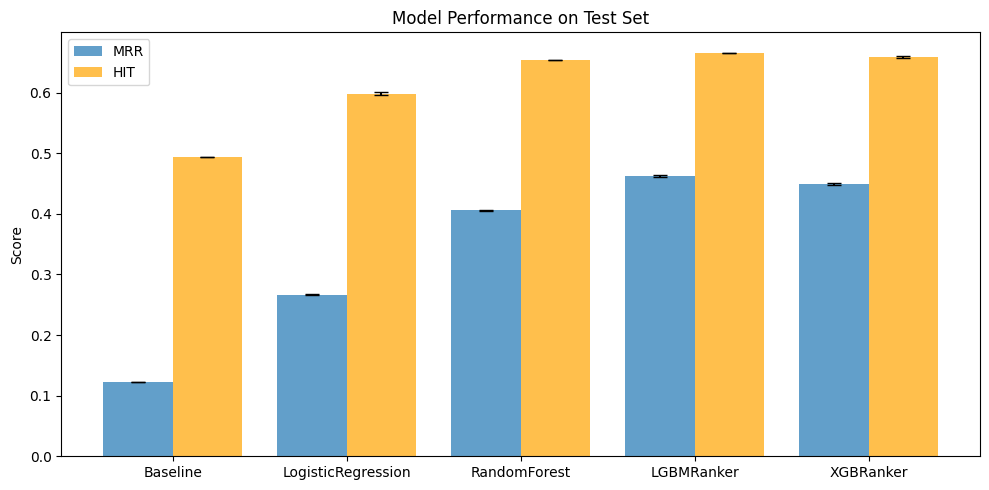

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 将结果汇总成DataFrame
data = {
    'Model': ['Baseline', 'LogisticRegression', 'RandomForest', 'LGBMRanker', 'XGBRanker'],
    'Test_MRR': [0.1222, 0.2666, 0.4055, 0.4624, 0.4491],
    'Test_HIT': [0.4932, 0.5984, 0.6536, 0.6657, 0.6588],
    'MRR_std': [0.0, 0.0010, 0.0016, 0.0011, 0.0023],  
    'HIT_std': [0.0, 0.0023, 0.0005, 0.0004, 0.0016]
}

df_results = pd.DataFrame(data)

plt.figure(figsize=(10,5))
x = np.arange(len(df_results))
bar_width = 0.4

plt.bar(x - bar_width/2, df_results['Test_MRR'], bar_width, yerr=df_results['MRR_std'], capsize=5, label='MRR', alpha=0.7)
plt.bar(x + bar_width/2, df_results['Test_HIT'], bar_width, yerr=df_results['HIT_std'], capsize=5, label='HIT', alpha=0.7, color='orange')

plt.xticks(x, df_results['Model'])
plt.ylabel('Score')
plt.title('Model Performance on Test Set')
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
def train():
    from sklearn.model_selection import GroupKFold, ParameterGrid, train_test_split
    import lightgbm as lgb
    import numpy as np
    import pandas as pd
    import shap
    import matplotlib.pyplot as plt
    import seaborn as sns

    best_params = {
        'colsample_bytree': 0.9,
        'learning_rate': 0.1,
        'n_estimators': 500,
        'num_leaves': 63,
        'reg_alpha': 0.0,
        'reg_lambda': 2.0,
        'subsample': 0.7
    }

    df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')

    users = df_train['user_id'].unique()
    train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)
    df_train_cv = df_train[df_train['user_id'].isin(train_users)]
    df_test_final = df_train[df_train['user_id'].isin(test_users)]

    X_train_cv, X_grp_train_cv, y_train_cv = prepare_dataset(df_train_cv)
    X_test_final, X_grp_test_final, y_test_final = prepare_dataset(df_test_final)

    def handle_columns(X):
        return X.drop(columns=['user_id', 'article_id'])

    _X_train_cv = handle_columns(X_train_cv)
    y_train_cv_np = y_train_cv.values if hasattr(y_train_cv, 'values') else y_train_cv
    group_array = X_train_cv['user_id'].values

    combined_user_ids = X_train_cv['user_id'].values
    grp_combined = pd.DataFrame({'user_id': combined_user_ids}).groupby('user_id', as_index=False).size()['size'].values

    final_clf = lgb.LGBMRanker(
        random_state=777, 
        eval_at=[1,2,3,4,5], 
        eval_metric='ndcg', 
        **best_params
    )
    final_clf.fit(_X_train_cv, y_train_cv, group=grp_combined)

    X_test_original = X_test_final.copy()
    _X_test_final = handle_columns(X_test_final)
    y_pred_test = final_clf.predict(_X_test_final, num_iteration=final_clf.best_iteration_)
    recommend_dict_test = make_recommend_dict(X_test_final, y_pred_test)
    answers_test = dict(df_test_final.loc[df_test_final['answer'] == 1, ['user_id', 'article_id']].values)
    mrr_test, hit_test, details_test = calc_mrr_and_hit(recommend_dict_test, answers_test)
    print("\n=== Test Set Results ===")
    print(f"Model MRR: {mrr_test:.4f} / HIT: {hit_test:.4f}")
    print("Detail Hits:", " / ".join(['%.2f' % d for d in details_test]))

    feature_importance = sorted(zip(_X_train_cv.columns, final_clf.feature_importances_), key=lambda x: x[1], reverse=True)
    print("\nFeature Importances:")
    for f, imp in feature_importance:
        print(f"{f}: {imp}")

    shap.initjs()
    explainer = shap.TreeExplainer(final_clf)
    shap_values = explainer.shap_values(_X_test_final)
    shap_df = pd.DataFrame(shap_values, columns=_X_test_final.columns)
    feature_shap_importance = shap_df.abs().mean().sort_values(ascending=False)
    feature_shap_importance_df = feature_shap_importance.reset_index()
    feature_shap_importance_df.columns = ['Feature', 'SHAP value']

    print("\nSHAP Feature Importances:")
    print(feature_shap_importance_df)

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    sns.barplot(x='SHAP value', y='Feature', data=feature_shap_importance_df)
    plt.title('Global Feature Importance based on SHAP')
    plt.xlabel('SHAP value')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    shap.summary_plot(shap_values, _X_test_final)

    indices = [0, 1000, 5000, 100000]
    for sample_idx in indices:
        if sample_idx < len(_X_test_final):
            display(shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], _X_test_final.iloc[sample_idx,:]))
        else:
            print(f"Sample index {sample_idx} is out of range.")

    return final_clf, feature_importance, X_test_original, recommend_dict_test, answers_test, y_pred_test


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 466513, number of used features: 18


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric

=== Test Set Results ===
Model MRR: 0.4633 / HIT: 0.6643
Detail Hits: 0.34 / 0.16 / 0.09 / 0.05 / 0.03

Feature Importances:
lag_period_last_article: 3549
lag_between_created_at_ts_and_clicked_ts: 3147
last_clicked_timestamp: 2776
words_count: 2449
diff_words_last_article: 2409
category_id: 2120
created_at_ts: 2034
lag_between_two_click: 2010
min_words_count: 1938
max_words_count: 1894
lag_between_two_articles: 1850
avg_words_count: 1806
click_region: 1466
click_referrer_type: 716
click_os: 435
click_deviceGroup: 261
click_country: 107
click_environment: 33


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(



SHAP Feature Importances:
                                     Feature  SHAP value
0                    lag_period_last_article    1.194113
1                                words_count    0.129797
2                                category_id    0.127745
3                              created_at_ts    0.111295
4                          click_deviceGroup    0.097051
5                     last_clicked_timestamp    0.076405
6   lag_between_created_at_ts_and_clicked_ts    0.067744
7                                   click_os    0.055254
8                    diff_words_last_article    0.043430
9                               click_region    0.042226
10                     lag_between_two_click    0.041257
11                       click_referrer_type    0.040336
12                           min_words_count    0.035952
13                           max_words_count    0.030980
14                  lag_between_two_articles    0.030782
15                           avg_words_count    0.029881
16  

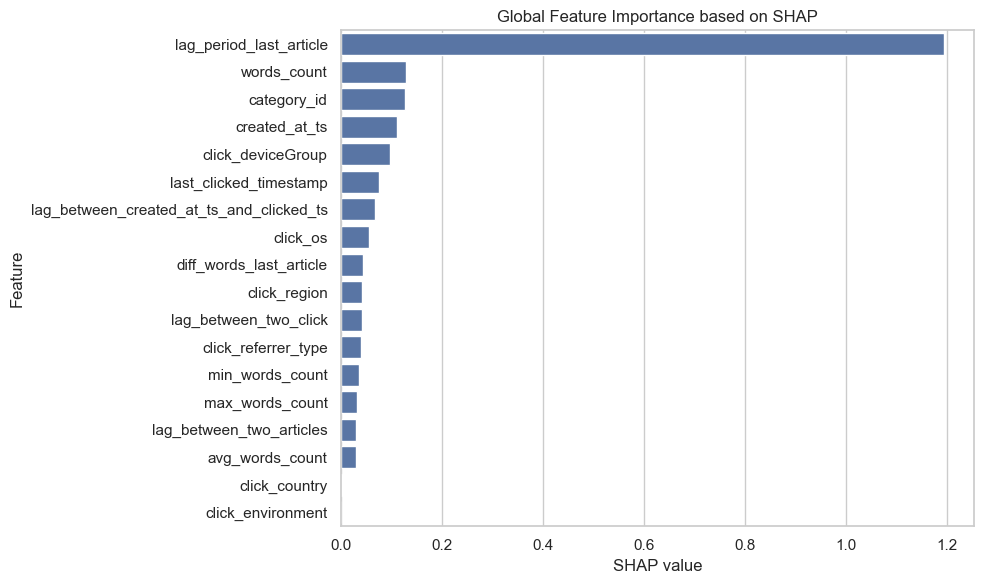

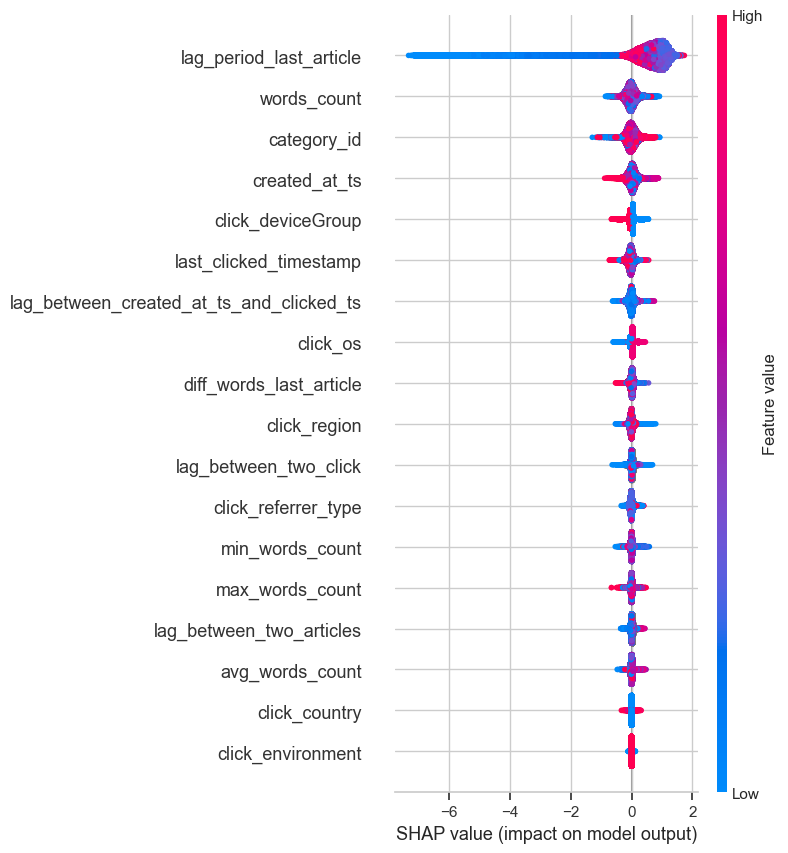

In [37]:
final_clf, feature_importance, _X_test_final, recommend_dict_test, answers_test, y_pred_test = train()

In [25]:


import shap

explainer = shap.TreeExplainer(final_clf)
shap_values = explainer.shap_values(_X_test_final)
indices = [0, 1000, 5000, 100000]

for sample_idx in indices:
    display(shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], _X_test_final.iloc[sample_idx,:]))
    



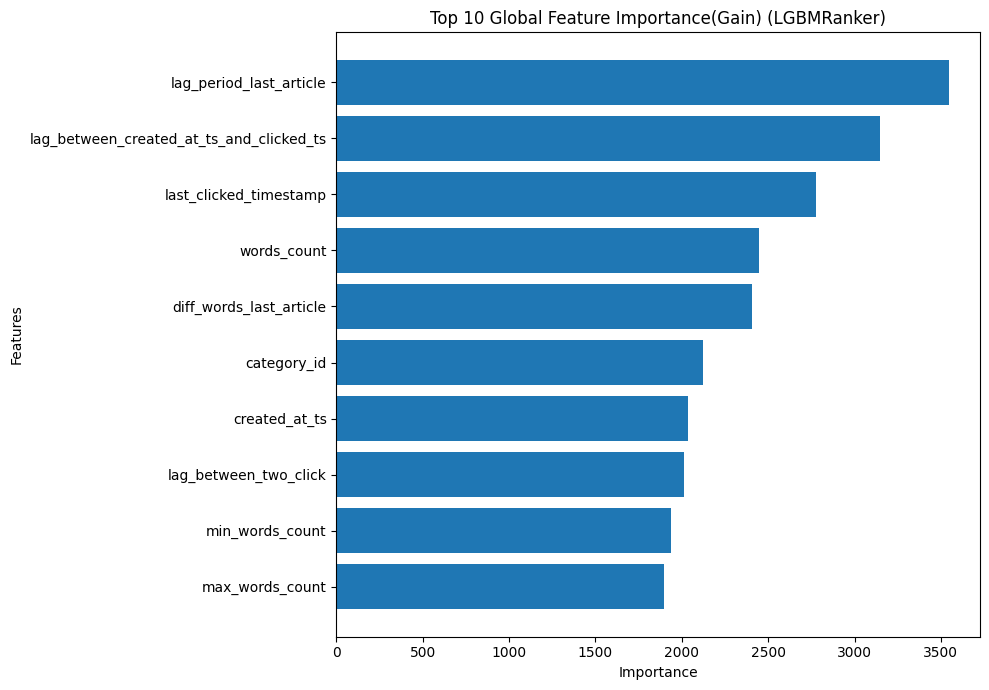

In [32]:
import matplotlib.pyplot as plt
fi_df = pd.DataFrame(feature_importance, columns=['feature','importance'])
top_n = 10
fi_df_top = fi_df.head(top_n)
fi_df_top = fi_df_top.sort_values(by='importance', ascending=True)

plt.figure(figsize=(10, 7))
plt.barh(fi_df_top['feature'], fi_df_top['importance'])
plt.title('Top 10 Global Feature Importance(Gain) (LGBMRanker)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()



Index(['user_id', 'last_clicked_timestamp', 'article_id', 'category_id',
       'created_at_ts', 'words_count', 'avg_words_count', 'min_words_count',
       'max_words_count', 'lag_between_created_at_ts_and_clicked_ts',
       'lag_between_two_click', 'lag_between_two_articles',
       'click_environment', 'click_deviceGroup', 'click_os', 'click_country',
       'click_region', 'click_referrer_type', 'lag_period_last_article',
       'diff_words_last_article'],
      dtype='object')


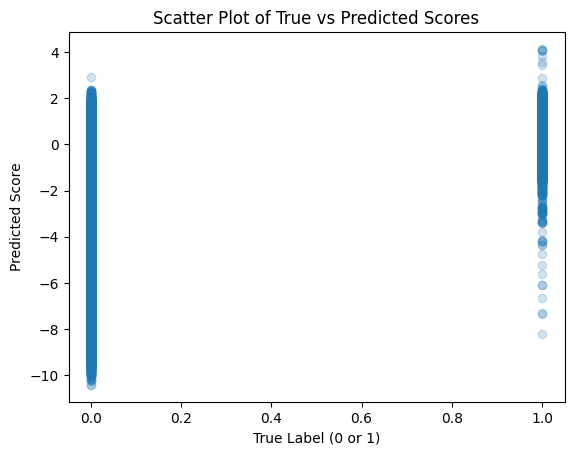

In [11]:
import matplotlib.pyplot as plt

print(_X_test_final.columns)
df_test_plot = _X_test_final.copy() 
df_test_plot['pred'] = y_pred_test
df_test_plot['answer'] = 0

uid_arr = df_test_plot['user_id'].values
aid_arr = df_test_plot['article_id'].values

for i in range(len(df_test_plot)):
    uid = uid_arr[i]
    aid = aid_arr[i]
    if uid in answers_test and answers_test[uid] == aid:
        df_test_plot.iat[i, df_test_plot.columns.get_loc('answer')] = 1

y_true = df_test_plot['answer'].values
y_score = df_test_plot['pred'].values

plt.figure()
plt.scatter(y_true, y_score, alpha=0.2)
plt.xlabel('True Label (0 or 1)')
plt.ylabel('Predicted Score')
plt.title('Scatter Plot of True vs Predicted Scores')
plt.show()


Confusion Matrix:
[[6714    0]
 [6559 6727]]


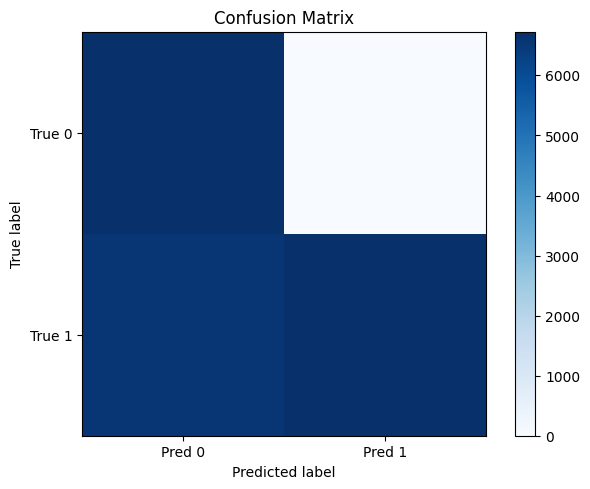

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for user_id, pred_list in recommend_dict_test.items():
    actual = 1 if user_id in answers_test and answers_test[user_id] in pred_list else 0
    
    predicted = 1 if (user_id in answers_test and pred_list[0] == answers_test[user_id]) else 0

    y_true.append(actual)
    y_pred.append(predicted)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ['Pred 0', 'Pred 1'])
plt.yticks([0,1], ['True 0', 'True 1'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

直接从文件i2i_30k_sim_offline.pkl中读取计算好的i2i_30k相似度


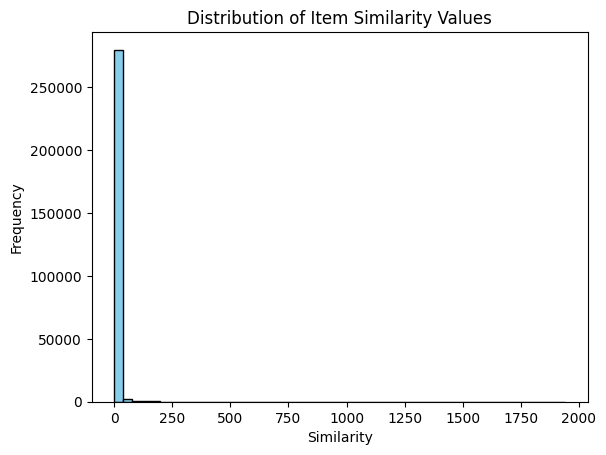

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
  
filename = 'i2i_30k_sim_{}.pkl'.format('offline')
print('直接从文件{}中读取计算好的i2i_30k相似度'.format(filename))
i2i_sim_dict = pickle.load(open(CACHE_FOLDER + filename, 'rb'))

all_items = list(i2i_sim_dict.keys())
sim_values = [val for related in i2i_sim_dict.values() for val in related['related_arts'].values()]
plt.hist(sim_values, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Item Similarity Values')
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()


In [30]:
def train():
    from sklearn.model_selection import GroupKFold, ParameterGrid
    import lightgbm as lgb
    import numpy as np
    import pandas as pd

    best_params = {
        'colsample_bytree': 0.9,
        'learning_rate': 0.1,
        'n_estimators': 500,
        'num_leaves': 63,
        'reg_alpha': 0.0,
        'reg_lambda': 2.0,
        'subsample': 0.7
    }

    df_train = pd.read_csv(CACHE_FOLDER + 'train.csv')

    users = df_train['user_id'].unique()
    train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)
    df_train_cv = df_train[df_train['user_id'].isin(train_users)]
    df_test_final = df_train[df_train['user_id'].isin(test_users)]

    X_train_cv, X_grp_train_cv, y_train_cv = prepare_dataset(df_train_cv)
    X_test_final, X_grp_test_final, y_test_final = prepare_dataset(df_test_final)

    def handle_columns(X):
        return X.drop(columns=['user_id', 'article_id'])

    _X_train_cv = handle_columns(X_train_cv)
    y_train_cv_np = y_train_cv.values if hasattr(y_train_cv, 'values') else y_train_cv
    group_array = X_train_cv['user_id'].values
    combined_user_ids = X_train_cv['user_id'].values
    grp_combined = pd.DataFrame({'user_id': combined_user_ids}).groupby('user_id', as_index=False).size()['size'].values

    final_clf = lgb.LGBMRanker(
        random_state=777, 
        eval_at=[1,2,3,4,5], 
        eval_metric='ndcg', 
        **best_params
    )
    final_clf.fit(_X_train_cv, y_train_cv, group=grp_combined,)

    X_test_original = X_test_final.copy()
    _X_test_final = handle_columns(X_test_final)
    y_pred_test = final_clf.predict(_X_test_final, num_iteration=final_clf.best_iteration_)
    recommend_dict_test = make_recommend_dict(X_test_final, y_pred_test)
    answers_test = dict(df_test_final.loc[df_test_final['answer'] == 1, ['user_id', 'article_id']].values)
    mrr_test, hit_test, details_test = calc_mrr_and_hit(recommend_dict_test, answers_test)
    print("\n=== Test Set Results ===")
    print(f"Model MRR: {mrr_test:.4f} / HIT: {hit_test:.4f}")
    print("Detail Hits:", " / ".join(['%.2f' % d for d in details_test]))

    feature_importance = sorted(zip(_X_train_cv.columns, final_clf.feature_importances_), key=lambda x: x[1], reverse=True)
    print("\nFeature Importances:")
    for f, imp in feature_importance:
        print(f"{f}: {imp}")

    # 返回所需变量
    return final_clf, feature_importance, X_test_original, recommend_dict_test, answers_test, y_pred_test


In [31]:
final_clf, feature_importance, _X_test_final, recommend_dict_test, answers_test, y_pred_test = train()

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 466513, number of used features: 18


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(



=== Test Set Results ===
Model MRR: 0.4633 / HIT: 0.6643
Detail Hits: 0.34 / 0.16 / 0.09 / 0.05 / 0.03

Feature Importances:
lag_period_last_article: 3549
lag_between_created_at_ts_and_clicked_ts: 3147
last_clicked_timestamp: 2776
words_count: 2449
diff_words_last_article: 2409
category_id: 2120
created_at_ts: 2034
lag_between_two_click: 2010
min_words_count: 1938
max_words_count: 1894
lag_between_two_articles: 1850
avg_words_count: 1806
click_region: 1466
click_referrer_type: 716
click_os: 435
click_deviceGroup: 261
click_country: 107
click_environment: 33


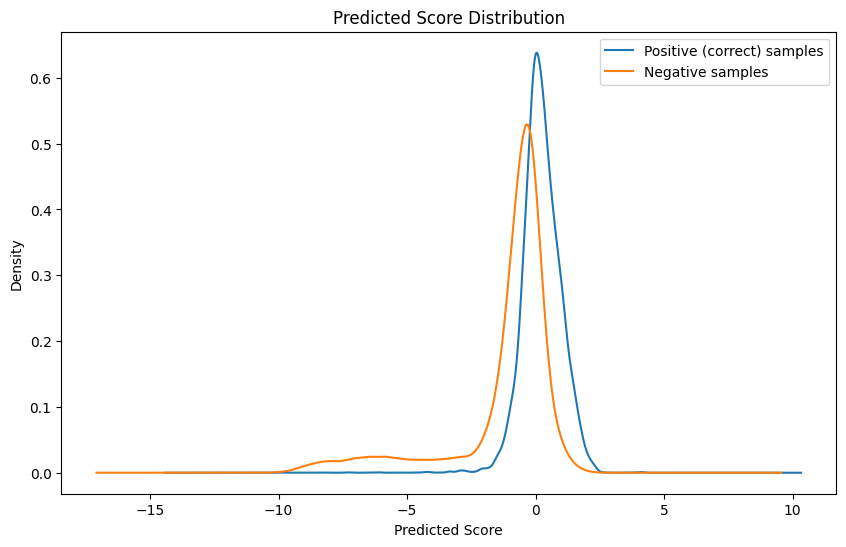

In [18]:
X_test_final_with_id = _X_test_final.copy()  # 包含user_id, article_id
X_test_final_with_id['pred'] = y_pred_test
X_test_final_with_id['answer'] = 0

uid_arr = X_test_final_with_id['user_id'].values
aid_arr = X_test_final_with_id['article_id'].values

for i in range(len(X_test_final_with_id)):
    uid = uid_arr[i]
    aid = aid_arr[i]
    if uid in answers_test and answers_test[uid] == aid:
        X_test_final_with_id.iat[i, X_test_final_with_id.columns.get_loc('answer')] = 1

# 分别提取正、负样本预测分数
pos_preds = X_test_final_with_id.loc[X_test_final_with_id['answer']==1, 'pred']
neg_preds = X_test_final_with_id.loc[X_test_final_with_id['answer']==0, 'pred']

plt.figure(figsize=(10,6))
pos_preds.plot(kind='kde', label='Positive (correct) samples')
neg_preds.plot(kind='kde', label='Negative samples')
plt.title('Predicted Score Distribution')
plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.legend()
plt.show()


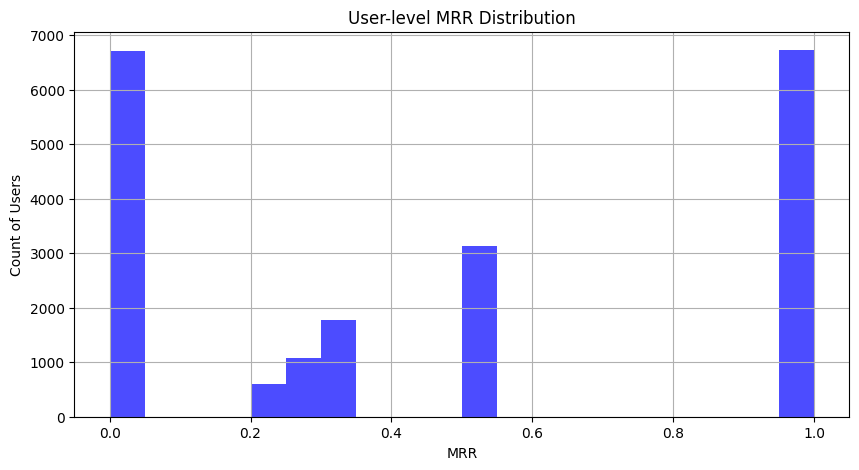

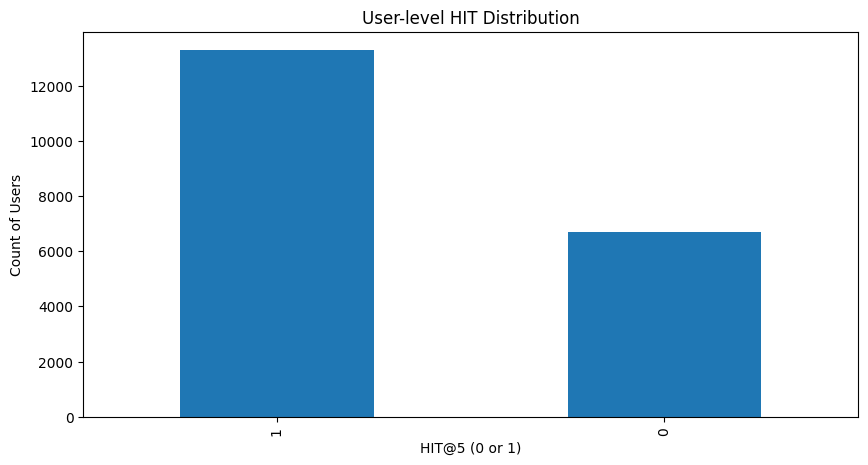

In [19]:
user_list = list(recommend_dict_test.keys())
user_mrr = []
user_hit = []

for uid in user_list:
    rec_list = recommend_dict_test[uid]
    answer = answers_test[uid] if uid in answers_test else None
    if answer in rec_list:
        pos_idx = rec_list.index(answer)
        # MRR(单用户)
        user_mrr.append(1/(pos_idx+1))
        user_hit.append(1 if pos_idx < 5 else 0)
    else:
        user_mrr.append(0)
        user_hit.append(0)

user_mrr = pd.Series(user_mrr)
user_hit = pd.Series(user_hit)

# 绘制用户MRR分布直方图
plt.figure(figsize=(10,5))
user_mrr.hist(bins=20, alpha=0.7, color='blue')
plt.title('User-level MRR Distribution')
plt.xlabel('MRR')
plt.ylabel('Count of Users')
plt.show()

# 用户HIT分布
plt.figure(figsize=(10,5))
user_hit.value_counts().plot(kind='bar')
plt.title('User-level HIT Distribution')
plt.xlabel('HIT@5 (0 or 1)')
plt.ylabel('Count of Users')
plt.show()


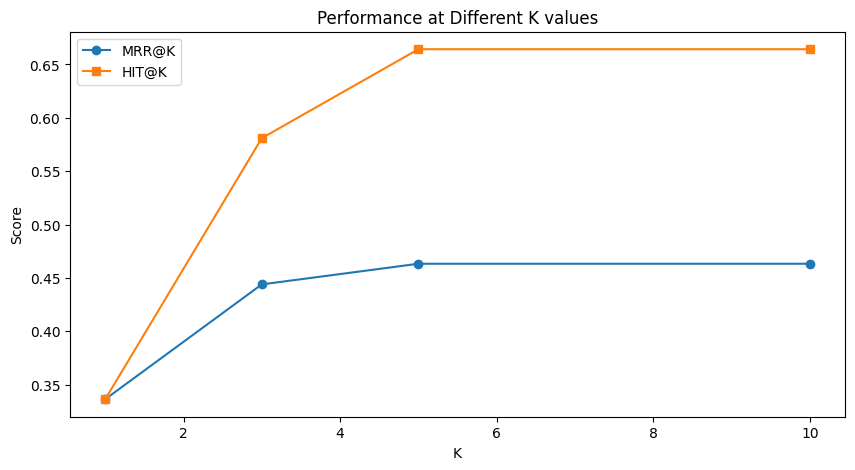

In [20]:
def calc_mrr_and_hit_k(recommend_dict, answers, k=5):
    sum_mrr = 0.0
    sum_hit = 0.0
    user_cnt = len(recommend_dict.keys())

    for user_id, recommend_items in recommend_dict.items():
        answer = answers[user_id] if user_id in answers else -1
        if answer in recommend_items:
            pos = recommend_items.index(answer)
            if pos < k:
                sum_hit += 1
                sum_mrr += 1/(pos+1)
    return (sum_mrr/user_cnt, sum_hit/user_cnt)

k_values = [1,3,5,10]
mrr_list = []
hit_list = []
for k in k_values:
    mrr_k, hit_k = calc_mrr_and_hit_k(recommend_dict_test, answers_test, k=k)
    mrr_list.append(mrr_k)
    hit_list.append(hit_k)

plt.figure(figsize=(10,5))
plt.plot(k_values, mrr_list, marker='o', label='MRR@K')
plt.plot(k_values, hit_list, marker='s', label='HIT@K')
plt.title('Performance at Different K values')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend()
plt.show()


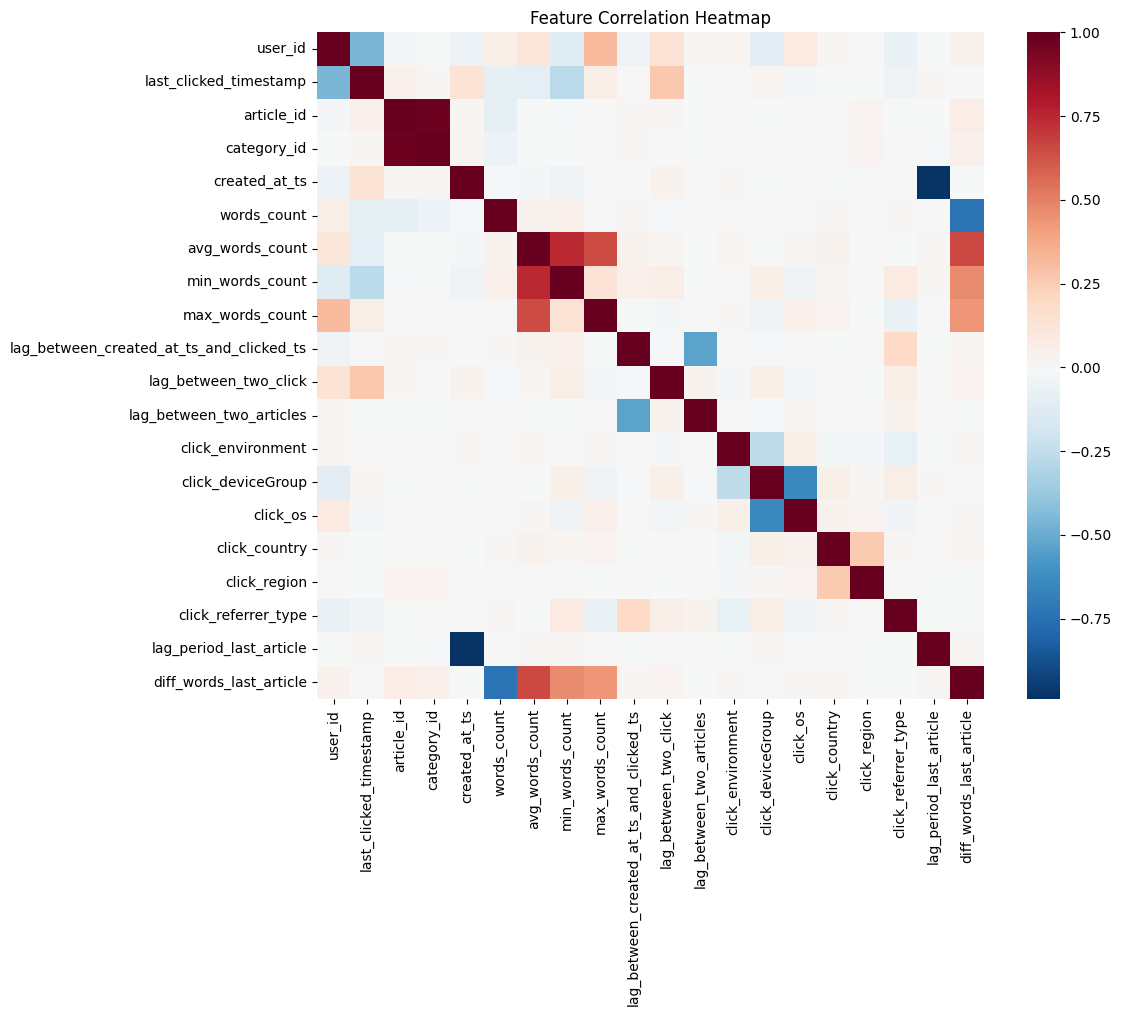

In [21]:
# 计算特征相关系数矩阵
corr = _X_test_final.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap='RdBu_r', center=0, annot=False, square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 466513, number of used features: 18


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _t = X_val.groupby('user_id')\
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/1386487952.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')



=== Test Set Results ===
Model MRR: 0.4633 / HIT: 0.6643
Detail Hits: 0.34 / 0.16 / 0.09 / 0.05 / 0.03

Feature Importances:
lag_period_last_article: 3549
lag_between_created_at_ts_and_clicked_ts: 3147
last_clicked_timestamp: 2776
words_count: 2449
diff_words_last_article: 2409
category_id: 2120
created_at_ts: 2034
lag_between_two_click: 2010
min_words_count: 1938
max_words_count: 1894
lag_between_two_articles: 1850
avg_words_count: 1806
click_region: 1466
click_referrer_type: 716
click_os: 435
click_deviceGroup: 261
click_country: 107
click_environment: 33


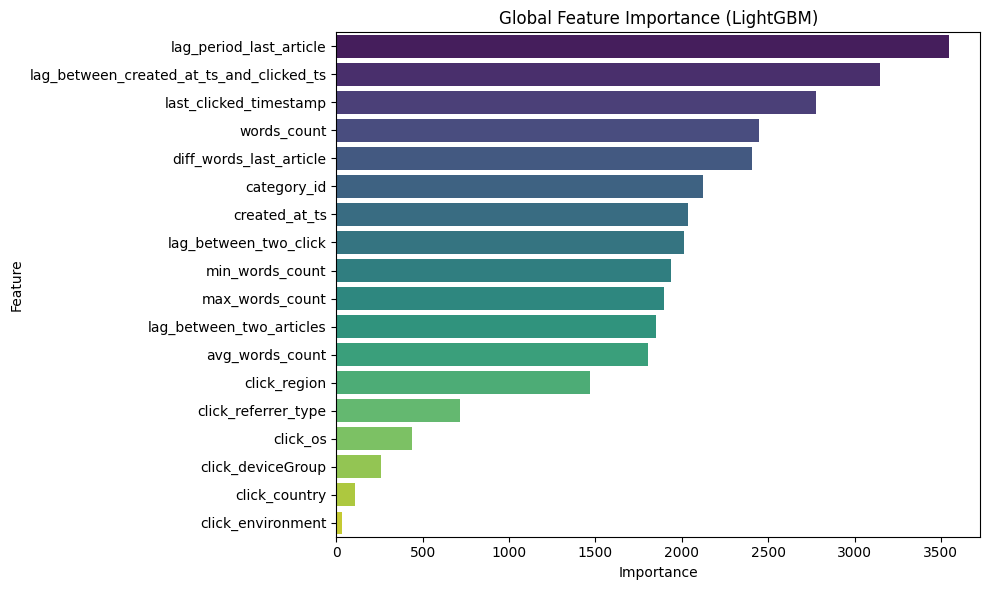

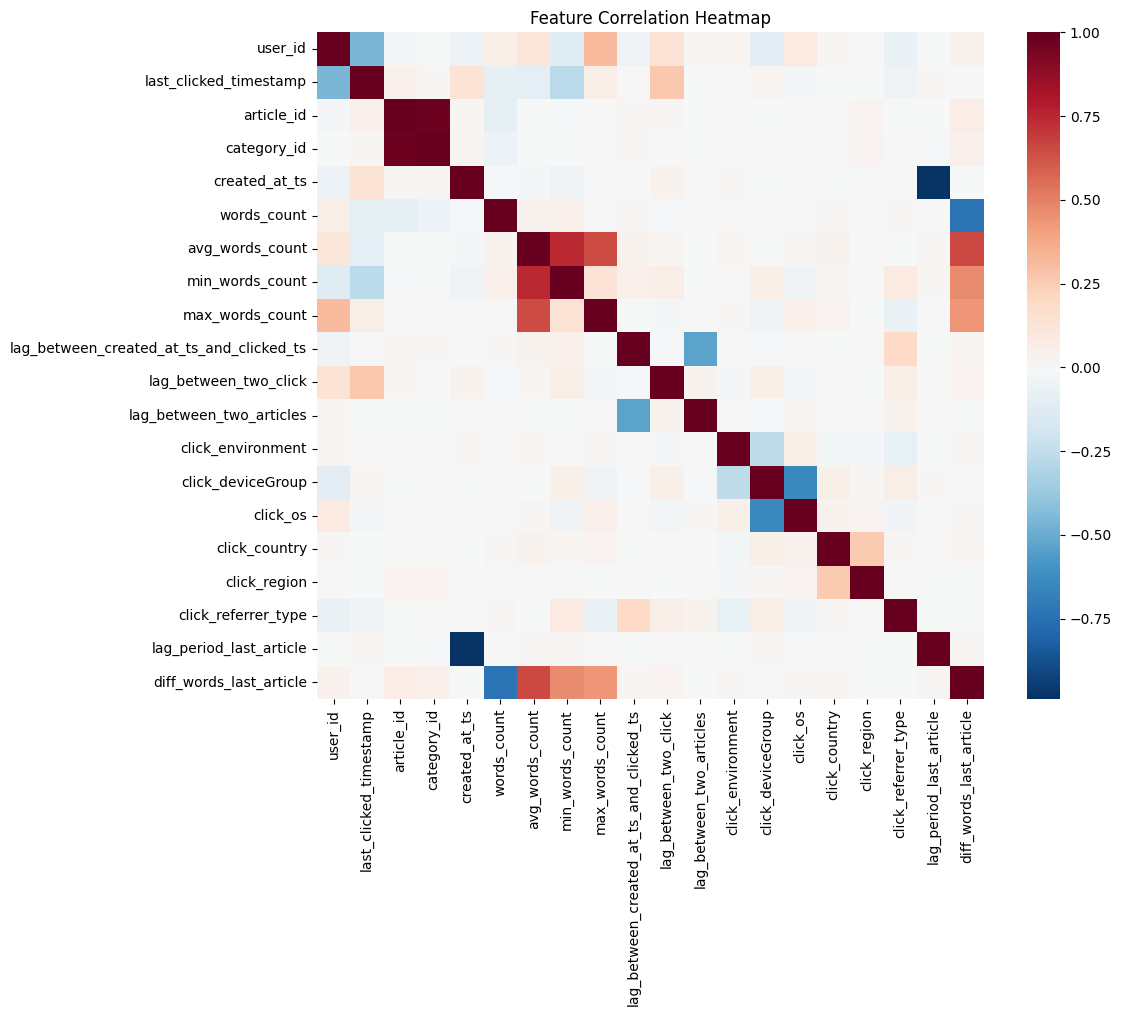

Highly correlated feature pairs (|corr| > 0.8):
article_id and category_id: 0.97
created_at_ts and lag_period_last_article: -0.99


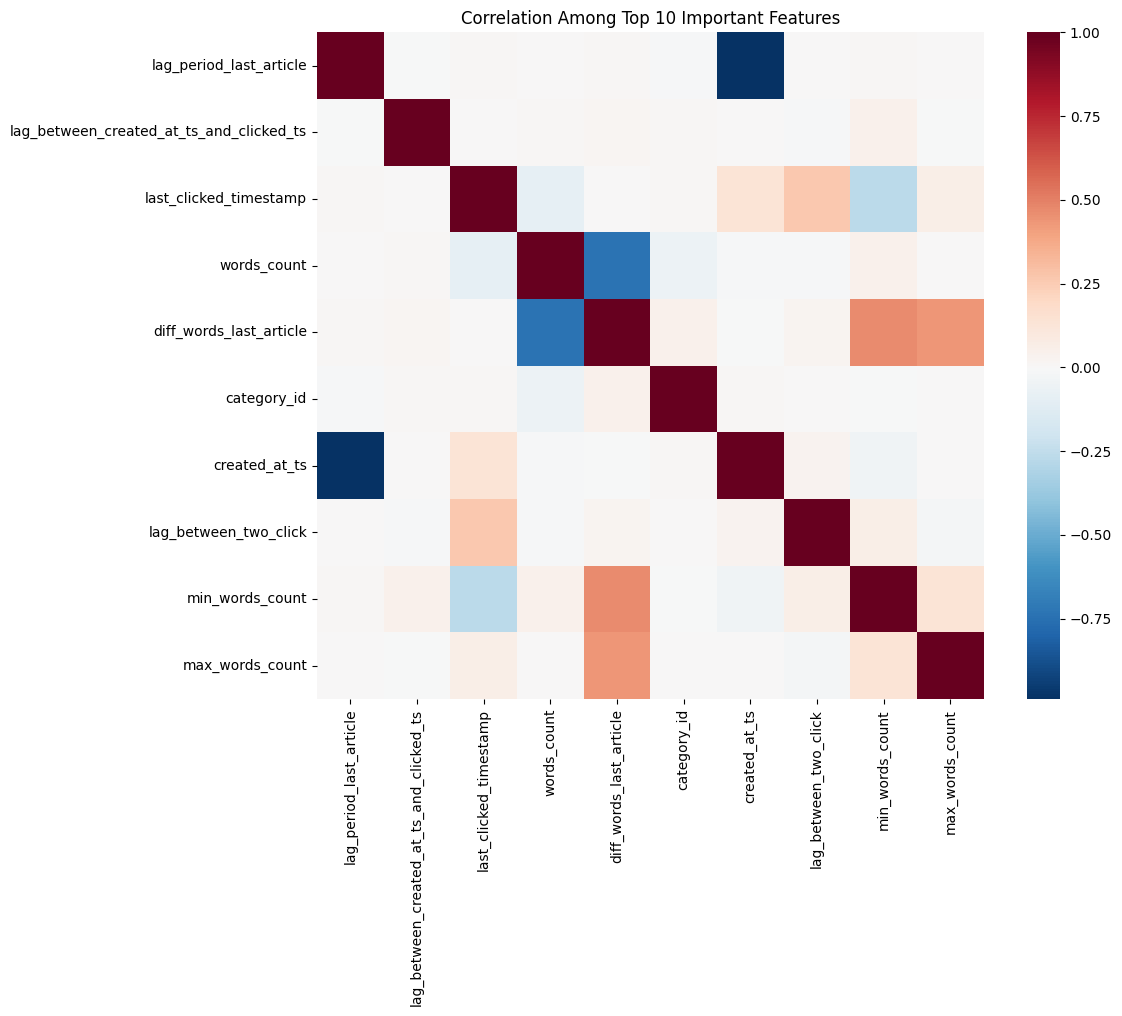

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/1386487952.py:73: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(pos_preds, label='Positive (Correct) Samples', shade=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/1386487952.py:74: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(neg_preds, label='Negative Samples', shade=True)


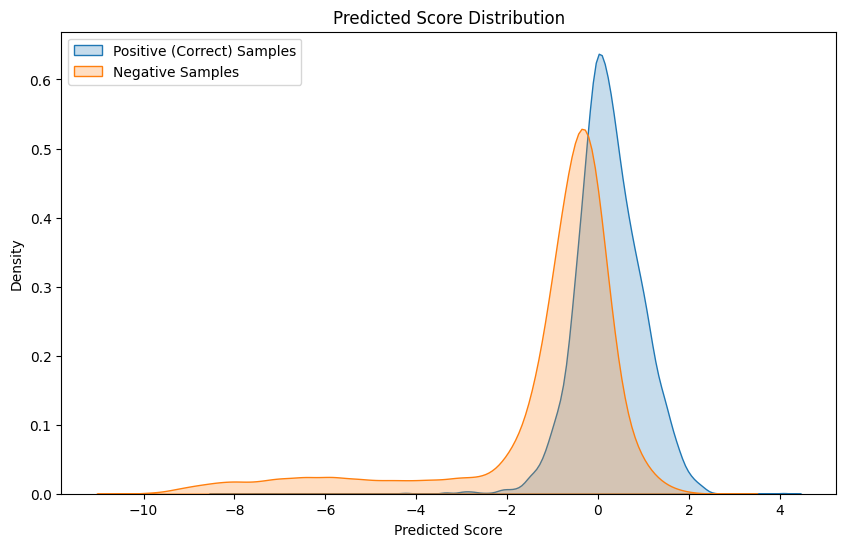

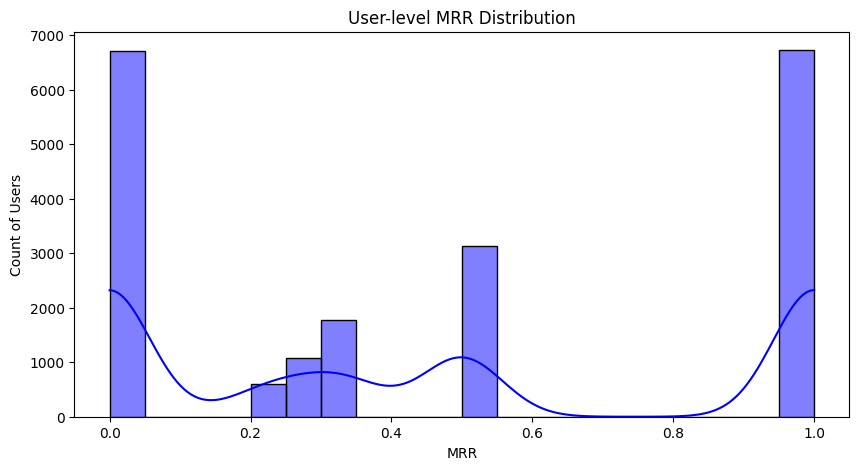

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/1386487952.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=user_hit, palette='Set2')


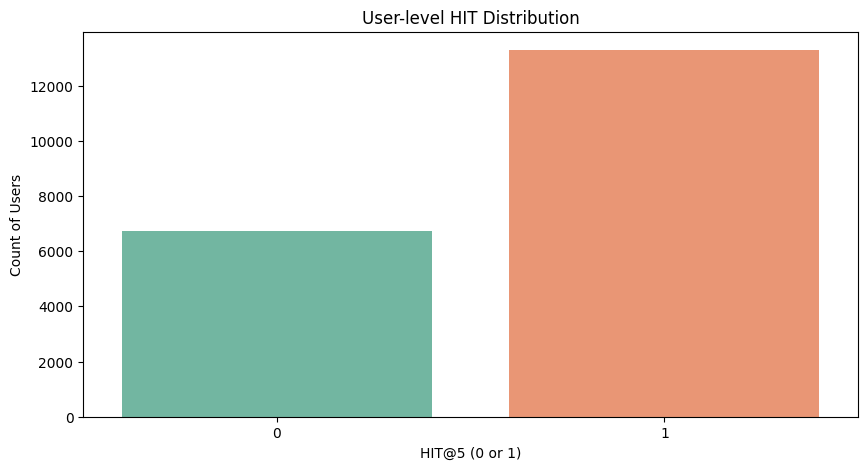

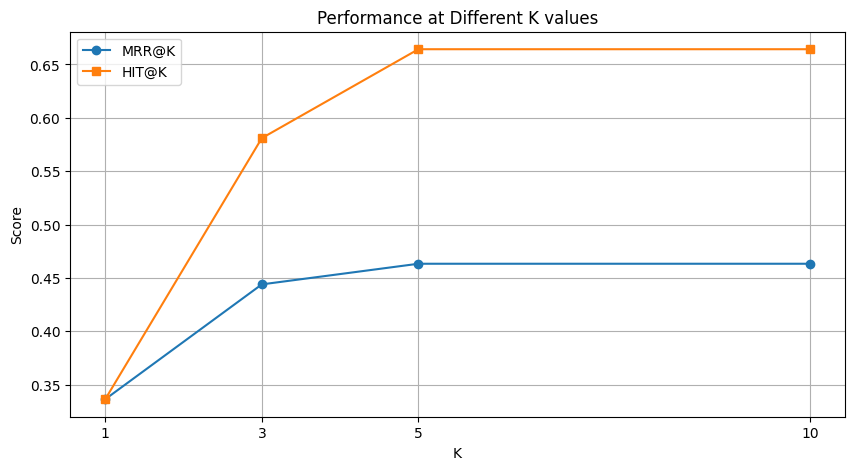

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb

# 假设已运行train函数并获取以下返回值
final_clf, feature_importance, _X_test_final, recommend_dict_test, answers_test, y_pred_test = train()

# 1. 绘制特征重要性条形图
fi_df = pd.DataFrame(feature_importance, columns=['feature','importance'])

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=fi_df, palette='viridis')
plt.title('Global Feature Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 2. 绘制特征相关性Heatmap
corr_matrix = _X_test_final.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, annot=False, square=True)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# 3. 检查和标记高度相关的特征
threshold = 0.8
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
            for x, y in zip(*np.where(upper_tri.abs() > threshold))]

print("Highly correlated feature pairs (|corr| > 0.8):")
for feat1, feat2, corr_val in high_corr:
    print(f"{feat1} and {feat2}: {corr_val:.2f}")

# 4. 结合特征重要性和相关性进行分析
top_features = fi_df['feature'].head(10).tolist()
top_corr = corr_matrix.loc[top_features, top_features]

plt.figure(figsize=(12,10))
sns.heatmap(top_corr, cmap='RdBu_r', center=0, annot=False, square=True)
plt.title('Correlation Among Top 10 Important Features')
plt.tight_layout()
plt.show()

# 5. 计算和绘制预测分数分布
# 假设你已经有user_id和article_id信息，确保在handle_columns前保留了这些列
# 这里假设X_test_final包含了user_id和article_id
# 如果没有，请参考之前的建议确保保留这些信息
X_test_final_with_id = _X_test_final.copy()
X_test_final_with_id['pred'] = y_pred_test
X_test_final_with_id['answer'] = 0

uid_arr = X_test_final_with_id['user_id'].values
aid_arr = X_test_final_with_id['article_id'].values

for i in range(len(X_test_final_with_id)):
    uid = uid_arr[i]
    aid = aid_arr[i]
    if uid in answers_test and answers_test[uid] == aid:
        X_test_final_with_id.iat[i, X_test_final_with_id.columns.get_loc('answer')] = 1

# 分别提取正、负样本预测分数
pos_preds = X_test_final_with_id.loc[X_test_final_with_id['answer']==1, 'pred']
neg_preds = X_test_final_with_id.loc[X_test_final_with_id['answer']==0, 'pred']

plt.figure(figsize=(10,6))
sns.kdeplot(pos_preds, label='Positive (Correct) Samples', shade=True)
sns.kdeplot(neg_preds, label='Negative Samples', shade=True)
plt.title('Predicted Score Distribution')
plt.xlabel('Predicted Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6. 用户级别指标分布
user_list = list(recommend_dict_test.keys())
user_mrr = []
user_hit = []

for uid in user_list:
    rec_list = recommend_dict_test[uid]
    answer = answers_test.get(uid, None)
    if answer in rec_list:
        pos_idx = rec_list.index(answer)
        # MRR(单用户)
        user_mrr.append(1/(pos_idx+1))
        user_hit.append(1 if pos_idx < 5 else 0)
    else:
        user_mrr.append(0)
        user_hit.append(0)

user_mrr = pd.Series(user_mrr)
user_hit = pd.Series(user_hit)

# 绘制用户MRR分布直方图
plt.figure(figsize=(10,5))
sns.histplot(user_mrr, bins=20, kde=True, color='blue')
plt.title('User-level MRR Distribution')
plt.xlabel('MRR')
plt.ylabel('Count of Users')
plt.show()

# 用户HIT分布
plt.figure(figsize=(10,5))
sns.countplot(x=user_hit, palette='Set2')
plt.title('User-level HIT Distribution')
plt.xlabel('HIT@5 (0 or 1)')
plt.ylabel('Count of Users')
plt.show()

# 7. 绘制不同K值下的HIT/MRR表现对比折线图
def calc_mrr_and_hit_k(recommend_dict, answers, k=5):
    sum_mrr = 0.0
    sum_hit = 0.0
    user_cnt = len(recommend_dict.keys())

    for user_id, recommend_items in recommend_dict.items():
        answer = answers.get(user_id, -1)
        if answer in recommend_items:
            pos = recommend_items.index(answer)
            if pos < k:
                sum_hit += 1
                sum_mrr += 1/(pos+1)
    return (sum_mrr/user_cnt, sum_hit/user_cnt)

k_values = [1,3,5,10]
mrr_list = []
hit_list = []
for k in k_values:
    mrr_k, hit_k = calc_mrr_and_hit_k(recommend_dict_test, answers_test, k=k)
    mrr_list.append(mrr_k)
    hit_list.append(hit_k)

plt.figure(figsize=(10,5))
plt.plot(k_values, mrr_list, marker='o', label='MRR@K')
plt.plot(k_values, hit_list, marker='s', label='HIT@K')
plt.title('Performance at Different K values')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.show()

# 8. SHAP Summary Plot（可选）
# 安装shap库: pip install shap



/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/2176331286.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values('user_id', inplace=True)
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2903
[LightGBM] [Info] Number of data points in the train set: 466513, number of used features: 18


/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")



=== Test Set Results ===
Model MRR: 0.4633 / HIT: 0.6643
Detail Hits: 0.34 / 0.16 / 0.09 / 0.05 / 0.03

Feature Importances:
lag_period_last_article: 3549
lag_between_created_at_ts_and_clicked_ts: 3147
last_clicked_timestamp: 2776
words_count: 2449
diff_words_last_article: 2409
category_id: 2120
created_at_ts: 2034
lag_between_two_click: 2010
min_words_count: 1938
max_words_count: 1894
lag_between_two_articles: 1850
avg_words_count: 1806
click_region: 1466
click_referrer_type: 716
click_os: 435
click_deviceGroup: 261
click_country: 107
click_environment: 33
基准性能 - MRR: 0.4633, HIT: 0.6643
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 last_clicked_timestamp 的置换完成 - MRR下降量: 0.0277, HIT下降量: 0.0035
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 category_id 的置换完成 - MRR下降量: 0.0542, HIT下降量: 0.0073
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 created_at_ts 的置换完成 - MRR下降量: 0.0374, HIT下降量: 0.0056
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 words_count 的置换完成 - MRR下降量: 0.0536, HIT下降量: 0.0082
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 avg_words_count 的置换完成 - MRR下降量: 0.0009, HIT下降量: -0.0010
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 min_words_count 的置换完成 - MRR下降量: 0.0041, HIT下降量: 0.0009
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 max_words_count 的置换完成 - MRR下降量: 0.0023, HIT下降量: 0.0003
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 lag_between_created_at_ts_and_clicked_ts 的置换完成 - MRR下降量: 0.0087, HIT下降量: -0.0009
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 lag_between_two_click 的置换完成 - MRR下降量: 0.0022, HIT下降量: 0.0003
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 lag_between_two_articles 的置换完成 - MRR下降量: 0.0001, HIT下降量: 0.0007
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_environment 的置换完成 - MRR下降量: 0.0001, HIT下降量: 0.0001
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_deviceGroup 的置换完成 - MRR下降量: -0.0003, HIT下降量: 0.0003
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_os 的置换完成 - MRR下降量: 0.0012, HIT下降量: 0.0002
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_country 的置换完成 - MRR下降量: 0.0000, HIT下降量: -0.0001
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_region 的置换完成 - MRR下降量: 0.0043, HIT下降量: 0.0013
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 click_referrer_type 的置换完成 - MRR下降量: 0.0032, HIT下降量: 0.0010
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/Users/liam/opt/anaconda3/envs/rec_sys/lib/python3.9/site-packages/lightgbm/sklearn.py:777: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")


特征 lag_period_last_article 的置换完成 - MRR下降量: 0.1300, HIT下降量: 0.0776
[LightGBM] [Warning] Unknown parameter: eval_metric


/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  recommend_dict = df.groupby('user_id').apply(
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='mrr_drop', y='feature', data=permutation_df, palette='viridis')


特征 diff_words_last_article 的置换完成 - MRR下降量: 0.0040, HIT下降量: -0.0002

Permutation Importance排序（按MRR下降量）:
                                     feature  mrr_drop  hit_drop
16                   lag_period_last_article  0.130007   0.07765
1                                category_id  0.054227   0.00730
3                                words_count  0.053608   0.00820
2                              created_at_ts  0.037442   0.00560
0                     last_clicked_timestamp  0.027722   0.00350
7   lag_between_created_at_ts_and_clicked_ts  0.008741  -0.00090
14                              click_region  0.004342   0.00130
5                            min_words_count  0.004144   0.00090
17                   diff_words_last_article  0.004025  -0.00020
15                       click_referrer_type  0.003220   0.00095
6                            max_words_count  0.002279   0.00035
8                      lag_between_two_click  0.002247   0.00030
12                                  click_os  0.0011

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:100: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:100: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:100: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:100: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:100: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/liam/opt

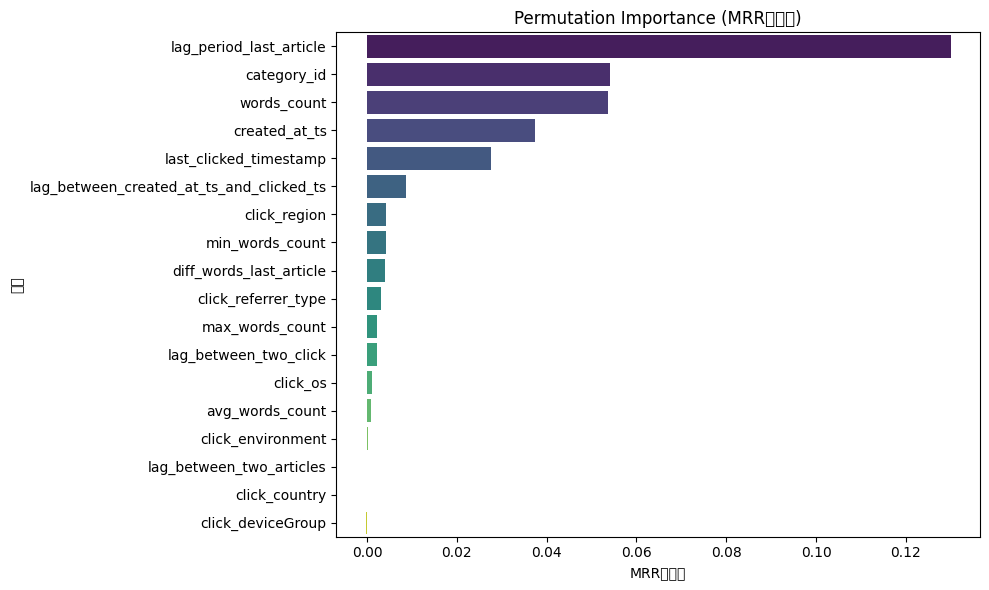

/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hit_drop', y='feature', data=permutation_df_hit_sorted, palette='magma')
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:109: UserWarning: Glyph 19979 (\N{CJK UNIFIED IDEOGRAPH-4E0B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:109: UserWarning: Glyph 38477 (\N{CJK UNIFIED IDEOGRAPH-964D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipykernel_81947/3395517182.py:109: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/zn/l5cxz1pd4dggzsrr48j0vt_c0000gn/T/ipy

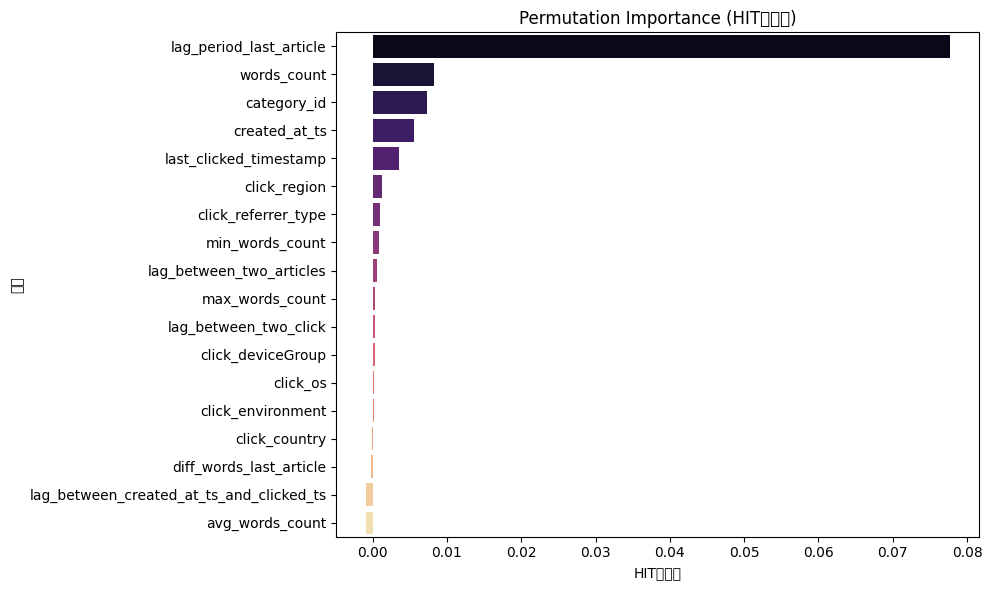

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def calc_mrr_and_hit(recommend_dict, answers, k=5):
    sum_mrr = 0.0
    sum_hit = 0.0
    user_cnt = len(recommend_dict)
    sum_hit_detail = np.zeros(k)
    
    for user_id, rec_list in recommend_dict.items():
        answer = answers.get(user_id, None)
        if answer in rec_list:
            pos = rec_list.index(answer)
            sum_mrr += 1/(pos+1)
            if pos < k:
                sum_hit += 1
                sum_hit_detail[pos] += 1

    return sum_mrr/user_cnt, sum_hit/user_cnt, sum_hit_detail/user_cnt

def make_recommend_dict(X, y_pred):
    # 假设X中包含'user_id','article_id'
    df = X.copy()
    df['pred'] = y_pred
    # 对每个用户按pred排序取前5篇文章
    recommend_dict = df.groupby('user_id').apply(
        lambda x: x.sort_values('pred', ascending=False)['article_id'].head(5).tolist()
    ).to_dict()
    return recommend_dict

def compute_permutation_importance(final_clf, X_test_original, answers_test, base_mrr, base_hit, recommend_dict_func, top_k=5):
    """
    计算Permutation Importance并返回DataFrame。
    :param final_clf: 训练好的LGBMRanker模型
    :param X_test_original: 原始测试数据（包含user_id、article_id等列）
    :param answers_test: 测试集用户答案字典
    :param base_mrr: 基准MRR
    :param base_hit: 基准HIT
    :param recommend_dict_func: 用于根据预测结果生成recommend_dict的函数（即make_recommend_dict）
    :param top_k: HIT和MRR计算的K值
    """
    # 去掉user_id和article_id列，仅保留特征
    features = [col for col in X_test_original.columns if col not in ['user_id','article_id','answer']]
    permutation_results = []

    for feature in features:
        X_shuffled = X_test_original.copy()
        # 对当前特征进行置换
        X_shuffled[feature] = np.random.permutation(X_shuffled[feature].values)
        
        # 处理特征列（drop user_id, article_id）
        _X_shuffled = X_shuffled.drop(columns=['user_id','article_id','answer'], errors='ignore')
        
        # 使用打乱后的数据预测
        y_pred_shuffled = final_clf.predict(_X_shuffled, num_iteration=final_clf.best_iteration_)
        recommend_dict_shuffled = recommend_dict_func(X_shuffled, y_pred_shuffled)
        
        # 计算新的MRR、HIT
        mrr_shuffled, hit_shuffled, _ = calc_mrr_and_hit(recommend_dict_shuffled, answers_test, k=top_k)
        
        mrr_drop = base_mrr - mrr_shuffled
        hit_drop = base_hit - hit_shuffled
        
        permutation_results.append((feature, mrr_drop, hit_drop))
        print(f"特征 {feature} 的置换完成 - MRR下降量: {mrr_drop:.4f}, HIT下降量: {hit_drop:.4f}")

    permutation_df = pd.DataFrame(permutation_results, columns=['feature','mrr_drop','hit_drop'])
    permutation_df.sort_values('mrr_drop', ascending=False, inplace=True)
    return permutation_df

final_clf, feature_importance, X_test_original, recommend_dict_test, answers_test, y_pred_test = train()

# 计算基准性能
base_mrr, base_hit, _ = calc_mrr_and_hit(recommend_dict_test, answers_test, k=5)
print(f"基准性能 - MRR: {base_mrr:.4f}, HIT: {base_hit:.4f}")

# 计算Permutation Importance
permutation_df = compute_permutation_importance(
    final_clf=final_clf,
    X_test_original=X_test_original,
    answers_test=answers_test,
    base_mrr=base_mrr,
    base_hit=base_hit,
    recommend_dict_func=make_recommend_dict,
    top_k=5
)

# 打印排序后的结果
print("\nPermutation Importance排序（按MRR下降量）:")
print(permutation_df.head(20))

# 绘制条形图
plt.figure(figsize=(10,6))
sns.barplot(x='mrr_drop', y='feature', data=permutation_df, palette='viridis')
plt.title('Permutation Importance (MRR下降量)')
plt.xlabel('MRR下降量')
plt.ylabel('特征')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
permutation_df_hit_sorted = permutation_df.sort_values('hit_drop', ascending=False)
sns.barplot(x='hit_drop', y='feature', data=permutation_df_hit_sorted, palette='magma')
plt.title('Permutation Importance (HIT下降量)')
plt.xlabel('HIT下降量')
plt.ylabel('特征')
plt.tight_layout()
plt.show()



Permutation Importance排序（按MRR下降量）:
                                     feature  mrr_drop  hit_drop
16                   lag_period_last_article  0.130007   0.07765
1                                category_id  0.054227   0.00730
3                                words_count  0.053608   0.00820
2                              created_at_ts  0.037442   0.00560
0                     last_clicked_timestamp  0.027722   0.00350
7   lag_between_created_at_ts_and_clicked_ts  0.008741  -0.00090
14                              click_region  0.004342   0.00130
5                            min_words_count  0.004144   0.00090
17                   diff_words_last_article  0.004025  -0.00020
15                       click_referrer_type  0.003220   0.00095
6                            max_words_count  0.002279   0.00035
8                      lag_between_two_click  0.002247   0.00030
12                                  click_os  0.001183   0.00020
4                            avg_words_count  0.000937

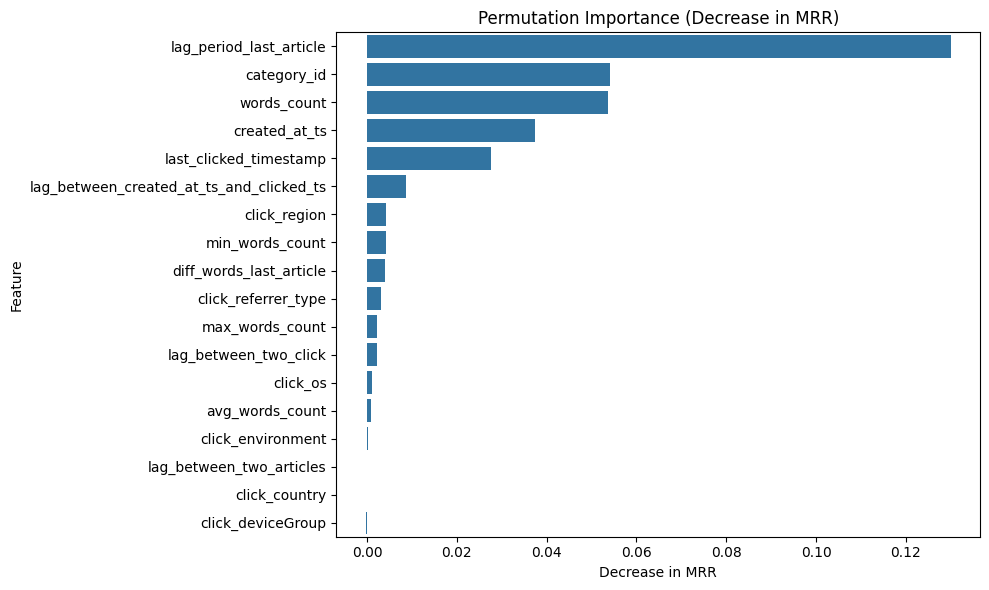

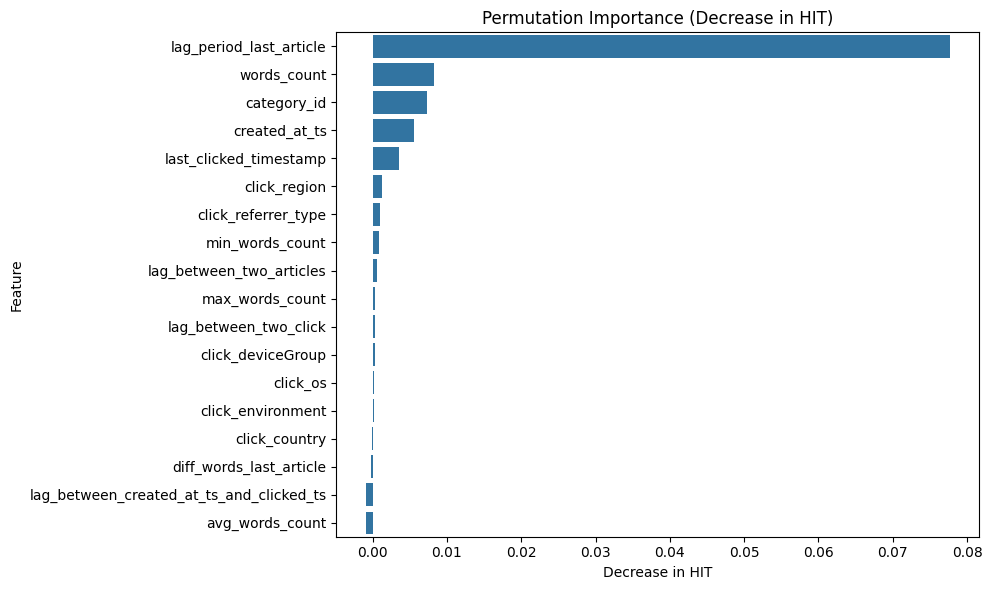

In [29]:
# 打印排序后的结果
print("\nPermutation Importance排序（按MRR下降量）:")
print(permutation_df.head(20))

# 绘制条形图
plt.figure(figsize=(10,6))
sns.barplot(x='mrr_drop', y='feature', data=permutation_df)
plt.title('Permutation Importance (Decrease in MRR)')
plt.xlabel('Decrease in MRR')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
permutation_df_hit_sorted = permutation_df.sort_values('hit_drop', ascending=False)
sns.barplot(x='hit_drop', y='feature', data=permutation_df_hit_sorted)
plt.title('Permutation Importance (Decrease in HIT)')
plt.xlabel('Decrease in HIT')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

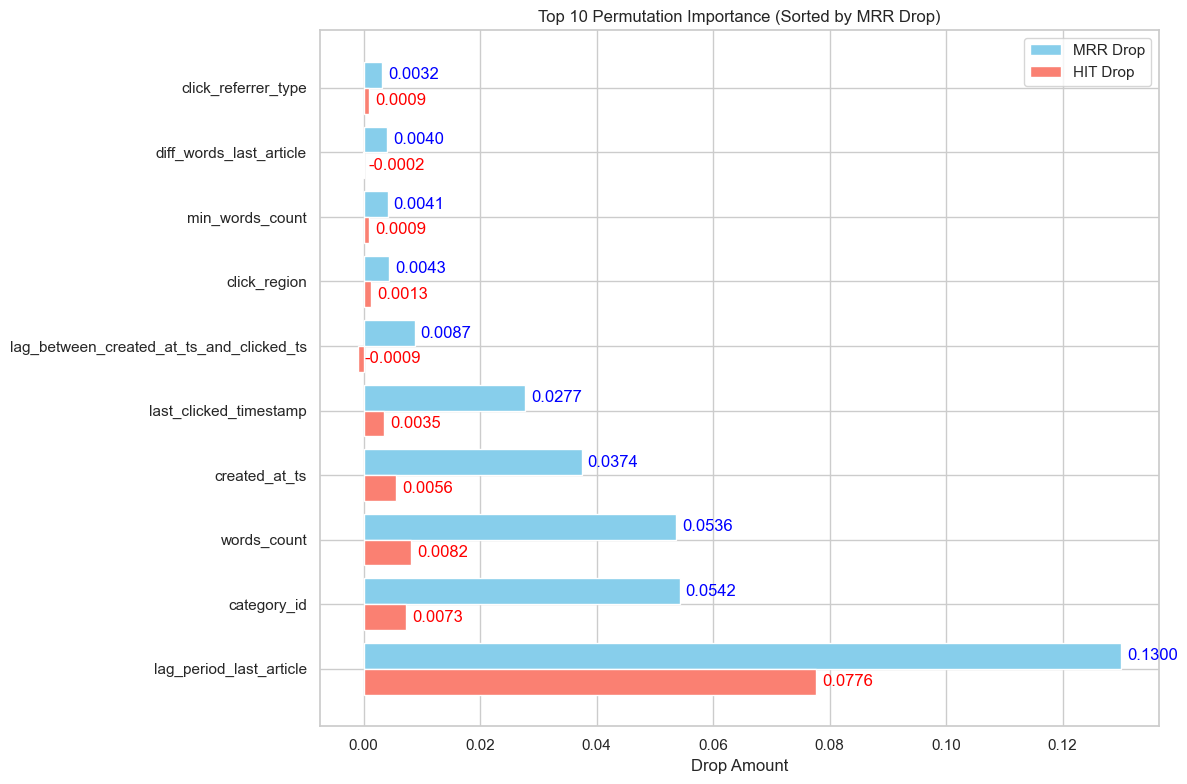

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 创建示例数据
data = {
    'feature': [
        'lag_period_last_article', 'category_id', 'words_count', 'created_at_ts',
        'last_clicked_timestamp', 'lag_between_created_at_ts_and_clicked_ts',
        'click_region', 'min_words_count', 'diff_words_last_article',
        'click_referrer_type', 'max_words_count', 'lag_between_two_click',
        'click_os', 'avg_words_count', 'click_environment',
        'lag_between_two_articles', 'click_country', 'click_deviceGroup'
    ],
    'mrr_drop': [
        0.130007, 0.054227, 0.053608, 0.037442, 0.027722, 0.008741,
        0.004342, 0.004144, 0.004025, 0.003220, 0.002279, 0.002247,
        0.001183, 0.000937, 0.000124, 0.000066, 0.000024, -0.000298
    ],
    'hit_drop': [
        0.07765, 0.00730, 0.00820, 0.00560, 0.00350, -0.00090,
        0.00130, 0.00090, -0.00020, 0.00095, 0.00035, 0.00030,
        0.00020, -0.00095, 0.00015, 0.00065, -0.00015, 0.00030
    ]
}

df = pd.DataFrame(data)

# 选择 Top 10 特征
top10_df = df.sort_values(by='mrr_drop', ascending=False).head(10)

# 设置绘图风格
sns.set(style="whitegrid")

# 设置图形大小
plt.figure(figsize=(12, 8))

# 设置条形图的位置和宽度
bar_width = 0.4
indices = range(len(top10_df))

# 绘制 MRR 下降量的条形图
plt.barh(
    [x + bar_width/2 for x in indices],
    top10_df['mrr_drop'],
    height=bar_width,
    color='skyblue',
    label='MRR Drop'
)

# 添加 MRR Drop 数据标签
for i, v in enumerate(top10_df['mrr_drop']):
    plt.text(v + 0.001, i + bar_width/2, f"{v:.4f}", color='blue', va='center')

# 绘制 HIT 下降量的条形图
plt.barh(
    [x - bar_width/2 for x in indices],
    top10_df['hit_drop'],
    height=bar_width,
    color='salmon',
    label='HIT Drop'
)

# 添加 HIT Drop 数据标签
for i, v in enumerate(top10_df['hit_drop']):
    plt.text(v + 0.001, i - bar_width/2, f"{v:.4f}", color='red', va='center')

# 设置 y轴标签
plt.yticks(indices, top10_df['feature'])

# 设置标签和标题
plt.xlabel('Drop Amount')
plt.title('Top 10 Permutation Importance (Sorted by MRR Drop)')

# 添加图例
plt.legend()

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()



### LGBMRanker Parameter Grid

| Parameter         | Values                          |
|-------------------|---------------------------------|
| n_estimators      | [300, 500, 1000]                |
| num_leaves        | [31, 63, 127]                   |
| reg_alpha         | [0.0, 0.1, 0.3, 0.5]            |
| reg_lambda        | [0.5, 1.0, 2.0, 5.0]            |
| subsample         | [0.5, 0.7, 0.9, 1.0]            |
| colsample_bytree  | [0.5, 0.7, 0.9, 1.0]            |
| min_child_samples | [20, 50, 100]                   |

### Logistic Regression Parameter Grid

| Parameter | Values                    |
|-----------|---------------------------|
| C         | [0.001, 0.01, 0.1, 1, 10] |
| max_iter  | [100, 200, 500]           |

### Random Forest Parameter Grid

| Parameter    | Values                    |
|--------------|---------------------------|
| max_depth    | [5, 10, 20, None]         |
| random_state | [42, 777]                 |

### XGBoost Parameter Grid

| Parameter        | Values               |
|------------------|----------------------|
| max_depth        | [3, 5, 7, 9]         |
| min_child_weight | [1, 5, 10]           |
| subsample        | [0.5, 0.7, 1.0]      |
| colsample_bytree | [0.5, 0.7, 1.0]      |
